# Analsis de Datos COVID-19 en Guatemala 2020

## Codigo Python

### Carga de datos

In [152]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

load_dotenv()

class SQLServerConnection:
    def __init__(self):
        self.server = os.getenv("SQL_SERVER_SERVER")
        self.database = os.getenv("SQL_SERVER_DATABASE")
        self.username = os.getenv("SQL_SERVER_USERNAME")
        self.password = os.getenv("SQL_SERVER_PASSWORD")
        self.port = os.getenv("SQL_SERVER_PORT")

    # f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    def get_connection(self):
        try:          
                    
            trusted_connection = 'yes'  # Utiliza 'yes' para Windows Authentication
            driver = '{SQL Server}'                   
            # Cadena de conexión para Windows Authentication
            # Especificar el controlador de pyodbc en la cadena de conexión
            connection_string = f'mssql+pyodbc://{self.server}/{self.database}?trusted_connection={trusted_connection}&driver=ODBC+Driver+17+for+SQL+Server'

            # connection_string = f'DRIVER={driver};SERVER={self.server};DATABASE={self.database};Trusted_Connection={trusted_connection}'
            engine = create_engine(connection_string)
            return engine
        except Exception as e:
            print(f"Error de conexión: {str(e)}")
            return None
         

#### Query's and dataframes

In [153]:
# Create connection
sql_server_connection = SQLServerConnection()
connection = sql_server_connection.get_connection()

print("connection: ", connection)

# Consulta SQL para extraer datos
sql_query_municipality =  """
SELECT M.code_municipality, M.municipality, M.population,
	   D.code_department, D.name_department,
	   C.code_country, C.name_country
FROM Municipality AS M
JOIN Department AS D ON M.code_department = D.code_department
JOIN Country AS C ON D.code_country = C.code_country;
"""
sql_query_department = 'SELECT * FROM Department'
sql_query_country_cases = 'SELECT * FROM Cases'
sql_query_mdp = """
SELECT
    M.municipality,
    MDR.code_municipality,
    MDR.date_reported,
    MDR.new_deaths,
    SUM(MDR.new_deaths) OVER (PARTITION BY MDR.code_municipality ORDER BY MDR.date_reported) AS cumulative_deaths
FROM
    MunicipalityDeathsReported MDR
JOIN
    Municipality M
        ON M.code_municipality = MDR.code_municipality
ORDER BY
    MDR.code_municipality, MDR.date_reported;
"""
sql_query_mdp_gt_0 = """
SELECT
    M.municipality,
    M.population,
    D.name_department,
    MDR.code_municipality,
    MDR.date_reported,
    MDR.new_deaths,
    SUM(MDR.new_deaths) OVER (PARTITION BY MDR.code_municipality ORDER BY MDR.date_reported) AS cumulative_deaths
FROM
    MunicipalityDeathsReported MDR
JOIN
    Municipality M
        ON M.code_municipality = MDR.code_municipality
JOIN
    Department D
        ON M.code_department = D.code_department
WHERE
    MDR.new_deaths > 0
ORDER BY
    MDR.code_municipality, MDR.date_reported;
"""

# Ejecutar la consulta y cargar los resultados en DataFrames
df_municipality = pd.read_sql(sql_query_municipality, connection)
df_department = pd.read_sql(sql_query_department, connection)
df_country_cases = pd.read_sql(sql_query_country_cases, connection)
df_mdp = pd.read_sql(sql_query_mdp, connection)
df_mdp_gt_0 = pd.read_sql(sql_query_mdp_gt_0, connection)

df_municipality = df_municipality.drop_duplicates()
df_department = df_department.drop_duplicates()
df_country_cases = df_country_cases.drop_duplicates()
df_mdp = df_mdp.drop_duplicates()
df_mdp_gt_0 = df_mdp_gt_0.drop_duplicates()

connection:  Engine(mssql+pyodbc://DESKTOP-4JJFHV8\SQLEXPRESS/ss2?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes)


In [154]:
df_mdp_gt_0.head()

municipality  population name_department code_municipality date_reported  \
0  MAZATENANGO       83448   SUCHITEPEQUEZ              1001    2020-05-16   
1  MAZATENANGO       83448   SUCHITEPEQUEZ              1001    2020-05-19   
2  MAZATENANGO       83448   SUCHITEPEQUEZ              1001    2020-06-28   
3  MAZATENANGO       83448   SUCHITEPEQUEZ              1001    2020-07-02   
4  MAZATENANGO       83448   SUCHITEPEQUEZ              1001    2020-07-03   

   new_deaths  cumulative_deaths  
0           1                  1  
1           1                  2  
2           1                  3  
3           1                  4  
4           1                  5

In [155]:
df_municipality.head()

code_municipality municipality  population code_department name_department  \
0              1001  MAZATENANGO       83448              10   SUCHITEPEQUEZ   
1              1002  CUYOTENANGO       37283              10   SUCHITEPEQUEZ   
2              1008      SAMAYAC       26350              10   SUCHITEPEQUEZ   
3               101    GUATEMALA     1205668               1       GUATEMALA   
4              1013     CHICACAO       67994              10   SUCHITEPEQUEZ   

  code_country name_country  
0           GT    Guatemala  
1           GT    Guatemala  
2           GT    Guatemala  
3           GT    Guatemala  
4           GT    Guatemala

### Funciones para análisis de datos

#### Funciones histogramas log, de caja, histogramas estándares y análisis estadísticos

In [156]:
def plot_analysis(df, variable_name):
    # Filtra los valores mayores que cero
    filtered_data = df[variable_name][df[variable_name] > 0]

    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear una figura con subgráficos
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Histograma con la transformación logarítmica
    sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', log_scale=True, ax=axes[0])
    axes[0].set_xlabel(f'Logaritmo de {variable_name}')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title(f'Histograma logarítmico de {variable_name}')

    # Diagrama de caja
    sns.boxplot(y=filtered_data, ax=axes[1])
    axes[1].set_ylabel(variable_name)
    axes[1].set_title(f'Diagrama de caja de {variable_name}')

    # Histograma estándar
    sns.histplot(filtered_data, bins=20, kde=True, edgecolor='black', ax=axes[2])
    axes[2].set_xlabel(variable_name)
    axes[2].set_ylabel('Frecuencia')
    axes[2].set_title(f'Histograma estándar de {variable_name}')

    # Estadísticas descriptivas
    statistics = filtered_data.describe()
    statistics_translated = statistics.rename(index={
        'count': 'Conteo',
        'mean': 'Promedio',
        'std': 'Desviación Estándar',
        'min': 'Mínimo',
        '25%': 'Cuartil 25%',
        '50%': 'Mediana',
        '75%': 'Cuartil 75%',
        'max': 'Máximo'
    })

    # Añadir estadísticas traducidas a la tabla
    axes[3].axis('off')
    axes[3].table(cellText=statistics_translated.reset_index().values,
                  colLabels=['Estadísticas', 'Valor'],
                  cellLoc='center', loc='center', colColours=['#f2f2f2']*2)
    axes[3].set_title(f'Estadísticas descriptivas de {variable_name}')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

def descr(df, variable_name):
    # Filtra los valores mayores que cero
    filtered_data = df[variable_name][df[variable_name] > 0]

    # Estadísticas descriptivas
    statistics = filtered_data.describe()
    statistics_translated = statistics.rename(index={
        'count': 'Conteo',
        'mean': 'Promedio',
        'std': 'Desviación Estándar',
        'min': 'Mínimo',
        '25%': 'Cuartil 25%',
        '50%': 'Mediana',
        '75%': 'Cuartil 75%',
        'max': 'Máximo'
    })
    print(f'Estadisticas monovariables de {variable_name}')
    print(statistics_translated, '\n')

#### Funcion datos multivariable cuantitativo: diagramas de dispersión

In [157]:
def scatter_plot(data, x_column, y_column, label_column, title, size=False):
    """
    Genera un gráfico de dispersión.

    Parámetros:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna para el eje x.
    - y_column: Nombre de la columna para el eje y.
    - label_column: Nombre de la columna para etiquetas de puntos.
    - title: Título del gráfico.
    - size: Nombre de la columna para el tamaño de los puntos (opcional).

    Ejemplo de uso:
    scatter_plot(df_mdp_gt_0, 'new_deaths', 'cumulative_deaths', 'municipality', 'Dispersión Nuevas Muertes vs Muertes Acumuladas', size=True)
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(12, 8))

    # Generar el gráfico de dispersión
    if size:
        sns.scatterplot(x=x_column, y=y_column, hue=label_column, size=size, sizes=(20, 200), data=data)
    else:
        sns.scatterplot(x=x_column, y=y_column, hue=label_column, data=data)

    # Añadir título y etiquetas de ejes
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)

    # Mostrar la leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.show()

def scatter_plot_multi(data, x_column, y_column, label_column, title, size=False, points_per_subplot=10, subplots_per_row=3):
    """
    Genera un gráfico de dispersión dividido en múltiples subgráficas.

    Parámetros:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna para el eje x.
    - y_column: Nombre de la columna para el eje y.
    - label_column: Nombre de la columna para etiquetas de puntos.
    - title: Título del gráfico.
    - size: Nombre de la columna para el tamaño de los puntos (opcional).
    - points_per_subplot: Cantidad de elementos por subgráfico.
    - subplots_per_row: Cantidad de subgráficas por fila.

    Ejemplo de uso:
    scatter_plot_multi(df_mdp_gt_0, 'new_deaths', 'cumulative_deaths', 'name_department', 'Dispersión Nuevas Muertes vs Muertes Acumuladas', size=True)
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Dividir los datos en grupos de 10 departamentos
    grouped_data = [group for _, group in data.groupby(label_column, sort=False)]
    grouped_data = [grouped_data[i:i + points_per_subplot] for i in range(0, len(grouped_data), points_per_subplot)]

    # Calcular la cantidad total de subgráficas
    total_subplots = len(grouped_data)
    
    # Calcular la cantidad total de filas necesarias
    total_rows = total_subplots // subplots_per_row + (1 if total_subplots % subplots_per_row else 0)
    
    # Crear subgráficas
    fig, axes = plt.subplots(total_rows, subplots_per_row, figsize=(20, 5 * total_rows))

    # Iterar sobre las subgráficas
    for i, group in enumerate(grouped_data):
        # Calcular la posición de la subgráfica
        row = i // subplots_per_row
        col = i % subplots_per_row
        
        # Configurar el tamaño del gráfico
        plt.sca(axes[row, col])
        
        # Concatenar los grupos y generar el gráfico de dispersión
        group_concatenated = pd.concat(group)
        if size:
            sns.scatterplot(x=x_column, y=y_column, hue=label_column, size=size, sizes=(20, 200), data=group_concatenated)
        else:
            sns.scatterplot(x=x_column, y=y_column, hue=label_column, palette='viridis', data=group_concatenated)

        # Añadir título y etiquetas de ejes
        plt.title(f'{title} - Parte {i + 1}')
        plt.xlabel(x_column)
        plt.ylabel(y_column)

        # Mostrar la leyenda
        plt.legend()

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()



#### Funcion datos cualitativos: histogramas count y sum de columnas según un dataset

In [158]:
def generate_count_plot(data, x_column, x_label, y_label, title, size=False):
    """
    Genera un diagrama de barras para el conteo de registros.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título del diagrama.
    - size: Booleano que indica si se usará un tamaño personalizado para la figura.

    Returns:
    None (muestra el diagrama y una tabla).
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear un diagrama de barras
    figsize = (50, 6) if size else (15, 6)
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=x_column, order=data[x_column].value_counts().index)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Mostrar la cantidad total de datos
    total_data = len(data)
    # print(f"Cantidad total de datos de {title}: {total_data}")

    # Mostrar una tabla con los resultados del histograma
    histogram_table = pd.DataFrame(data[x_column].value_counts()).reset_index()
    histogram_table.columns = [x_column, 'Count']
    # print(histogram_table)

    plt.show()


def generate_sum_plot(data, x_column, y_column, x_label, y_label, title, size=False):
    """
    Genera un diagrama de barras para el conteo de registros.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título del diagrama.
    - size: Booleano que indica si se usará un tamaño personalizado para la figura.
    - is_count: Booleano que indica si se realizará un conteo (True) o una suma (False).

    Returns:
    None (muestra el diagrama y una tabla).
    """
    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Crear un diagrama de barras
    figsize = (50, 6) if size else (15, 6)
    plt.figure(figsize=figsize)

    # Filtrar datos
    data_filtered = data[data[x_column] != 0]

    # Realizar una sumatoria de todos los valores en el DataFrame filtrado
    df_count = data_filtered.groupby(y_column).agg({x_column: 'sum'}).reset_index()
    df_count.columns = [x_column, 'Count']

    # Filtrar valores con al menos min_occurrences ocurrencias
    min_occurrences = 1  # Puedes ajustar este valor según tus necesidades
    values_to_plot = df_count[df_count['Count'] >= min_occurrences][x_column]

    # Usar values_to_plot para imprimir el histograma
    # print(values_to_plot)

    # Graficar el histograma
    sns.barplot(data=df_count, x=x_column, y='Count')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # Ordenar df_count por la columna 'Count' en orden descendente
    df_count_sorted = df_count.sort_values(by='Count', ascending=False)

    # Imprimir la sumatoria de Count de "population"
    total_population = df_count_sorted['Count'].sum()
    # print(f"Sumatoria de Count de population en {title}: {total_population}")

    # Imprimir el top 5 de df_count
    # print("Top 5:")
    # print(df_count_sorted.head())

    # Imprimir los peores 5 de df_count
    # print("Peores 5:")
    # print(df_count_sorted.tail())
    plt.show()



#### Funcion para generar diagramas multivariables: diagramas de Barra y mapas de calor

In [159]:
def generate_bar(data, x_column, y_column, x_label, y_label, title, rotation=45, size=False):
    """
    Genera un diagrama de barras y un mapa de calor para variables multivariables.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - y_column: Nombre de la columna en el DataFrame para el eje y.
    - values_column: Nombre de la columna con los valores a mostrar en el mapa de calor.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título de los gráficos.
    - rotation: Ángulo de rotación de las etiquetas en el eje x (por defecto, 0).
    - size: Tamaño de los gráficos (por defecto, False).

    Returns:
    None (muestra el diagrama de barras y el mapa de calor).
    """
    sns.set(style="whitegrid")

    # Diagrama de Barras
    figsize = (15,6) if not size else (25, 6)
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x=x_column, y=y_column)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title + " - Diagrama de Barras")
    plt.xticks(rotation=rotation)  # Eliminamos el parámetro ha='right'
    plt.show()

def generate_multivariable_bar_subplots(data, x_column, y_column, x_label, y_label, title, rotation=0, size=False, bars_per_subplot=10, subplots_per_row=3):
    """
    Genera múltiples subgráficas de barras para variables multivariables.

    Parameters:
    - data: DataFrame que contiene los datos.
    - x_column: Nombre de la columna en el DataFrame para el eje x.
    - y_column: Nombre de la columna en el DataFrame para el eje y.
    - x_label: Etiqueta del eje x.
    - y_label: Etiqueta del eje y.
    - title: Título de las subgráficas.
    - rotation: Ángulo de rotación de las etiquetas en el eje x (por defecto, 0).
    - size: Tamaño de las barras (por defecto, False).
    - bars_per_subplot: Cantidad de barras por subgráfica.
    - subplots_per_row: Cantidad de subgráficas por fila.

    Returns:
    None (muestra las subgráficas de barras).
    """
    sns.set(style="whitegrid")

    # Dividir los datos en grupos de 10 elementos
    grouped_data = [group for _, group in data.groupby(x_column, sort=False)]
    grouped_data = [grouped_data[i:i + bars_per_subplot] for i in range(0, len(grouped_data), bars_per_subplot)]

    # Calcular la cantidad total de subgráficas
    total_subplots = len(grouped_data)
    
    # Calcular la cantidad total de filas necesarias
    total_rows = total_subplots // subplots_per_row + (1 if total_subplots % subplots_per_row else 0)
    
    # Crear subgráficas
    fig, axes = plt.subplots(total_rows, subplots_per_row, figsize=(20, 5 * total_rows))

    # Iterar sobre las subgráficas
    for i, group in enumerate(grouped_data):
        # Calcular la posición de la subgráfica
        row = i // subplots_per_row
        col = i % subplots_per_row
        
        # Configurar el tamaño del gráfico
        plt.sca(axes[row, col])
        
        # Concatenar los grupos y generar el gráfico de barras
        group_concatenated = pd.concat(group)
        sns.barplot(data=group_concatenated, x=x_column, y=y_column)
        
        # Establecer el límite superior del eje y
        max_y_value = data[y_column].max()
        plt.ylim(0, max_y_value + 1)  # Puedes ajustar el 1 según tus necesidades
        
        # Añadir título y etiquetas de ejes
        plt.title(f'{title} - Parte {i + 1}')
        plt.xlabel(x_label)
        plt.ylabel(y_label)

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()



def generate_heatmaps(df, x_column, y_column, x_label, y_label, title, min_occurrences=10, num_row_per_graph=10, num_plots_per_row=4, is_count=True):
    df_filtered = df[df[x_column] != 0]

    # Realizar el cálculo según el valor de is_count
    if is_count:
        # Contar las ocurrencias de cada valor en la columna y en el DataFrame filtrado
        df_count = df_filtered.groupby(y_column).size().reset_index(name='count')
    else:
        # Filtrar datos        
        # Realizar una sumatoria de todos los valores en el DataFrame filtrado
        df_count = df_filtered.groupby(y_column).agg({x_column: 'sum'}).reset_index()
        df_count.columns = [y_column, 'count']

    # Filtrar valores con al menos min_occurrences ocurrencias
    values_to_plot = df_count[df_count['count'] >= min_occurrences][y_column]

    # Dividir los valores en grupos de num_plots_per_row
    values_groups = np.array_split(values_to_plot, len(values_to_plot) // num_row_per_graph + 1)
    # print(values_groups)

    # Configurar el estilo de seaborn
    sns.set(style="whitegrid")

    # Calcular el número necesario de filas
    num_rows = max(1, len(values_groups) // num_plots_per_row + (1 if len(values_groups) % num_plots_per_row else 0))

    # Calcular el valor máximo global para 'count' entre los valores filtrados
    global_max_count = df_count[df_count[y_column].isin(values_to_plot)]['count'].max()

    # Crear subgráficas
    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 1 * num_row_per_graph))

    for i, values_group in enumerate(values_groups):
        # Filtrar el DataFrame original para el grupo actual
        df_group = df_filtered[df_filtered[y_column].isin(values_group)]

        # Contar las ocurrencias de cada valor en el DataFrame filtrado
        df_group_count = df_group.groupby(y_column).agg({x_column: 'sum'}).reset_index()
        df_group_count.columns = [y_column, 'count']

        # Crear un mapa de calor para el grupo actual
        ax = axes[i] if len(values_groups) == 1 else axes[i // num_plots_per_row, i % num_plots_per_row]
        sns.heatmap(df_group_count.pivot_table(index=y_column, values='count', aggfunc='sum'),
                    cmap=sns.color_palette("Spectral", as_cmap=True), annot=True, fmt='g', ax=ax,
                    vmin=0, vmax=global_max_count)  # Usar global_max_count en lugar de df_group_count['count'].max()

        # Añadir título
        ax.set_title(f'{y_label} - {i + 1}')

    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

## **EDA Monovariable**

### Datos cuantitativos

#### Graficos monovariables cuantitativos

**Análisis de la variable `population`**
| **Histograma logarítmico de `population`** | **Diagrama de caja de `population`** | **Histograma estándar de `population`** |
| ------------------ | ------------------ | ------------- |
| El histograma logarítmico muestra la distribución de las poblaciones de los municipios. La transformación logarítmica se aplicó para mejorar la visualización eliminando ceros y ajustando escalas. | El diagrama de caja presenta la variabilidad y distribución de las poblaciones de los municipios. Se observa una amplia gama de tamaños de población, con algunos municipios que tienen valores atípicos significativamente más altos. | El histograma estándar muestra la distribución de las poblaciones de los municipios sin la transformación logarítmica. La mayoría de los municipios tienen poblaciones moderadas, mientras que algunos tienen tamaños de población excepcionalmente altos. |

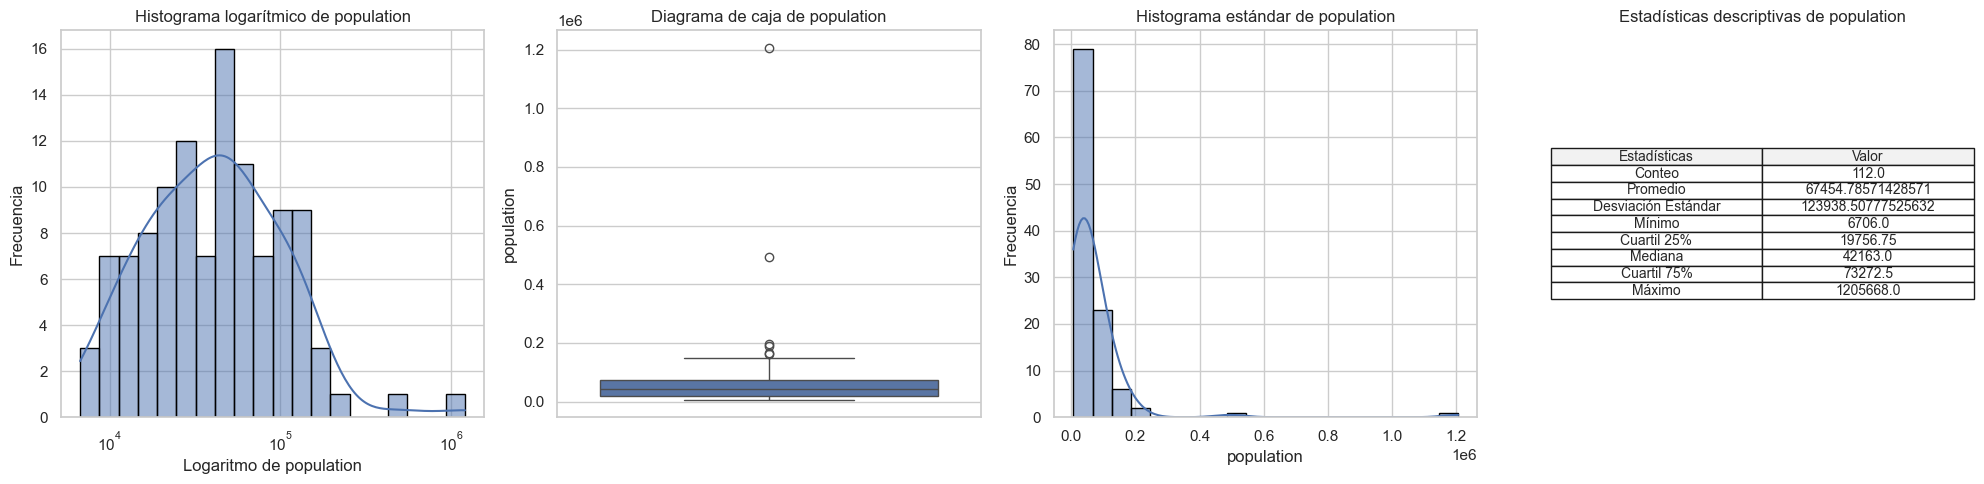

In [160]:
plot_analysis(df_municipality, 'population')

**Análisis de la variable `new_deaths`**

| **Histograma logarítmico de `new_deaths`** | **Diagrama de caja de `new_deaths`** | **Histograma estándar de `new_deaths`** |
| ------------------ | ------------------ | ----------------- |
| El histograma logarítmico muestra la distribución de nuevos casos de muerte diarios. La mayoría de los días registran una baja cantidad de nuevas muertes, pero hay algunos días con valores atípicos más altos. | El diagrama de caja presenta la variabilidad en el número de nuevas muertes diarias. La mayoría de los días tienen pocos casos, pero hay algunos días con valores atípicos más altos. | El histograma estándar muestra la distribución de nuevos casos de muerte diarios sin la transformación logarítmica. La mayoría de los días tienen pocas nuevas muertes, mientras que algunos días tienen valores excepcionalmente altos. |

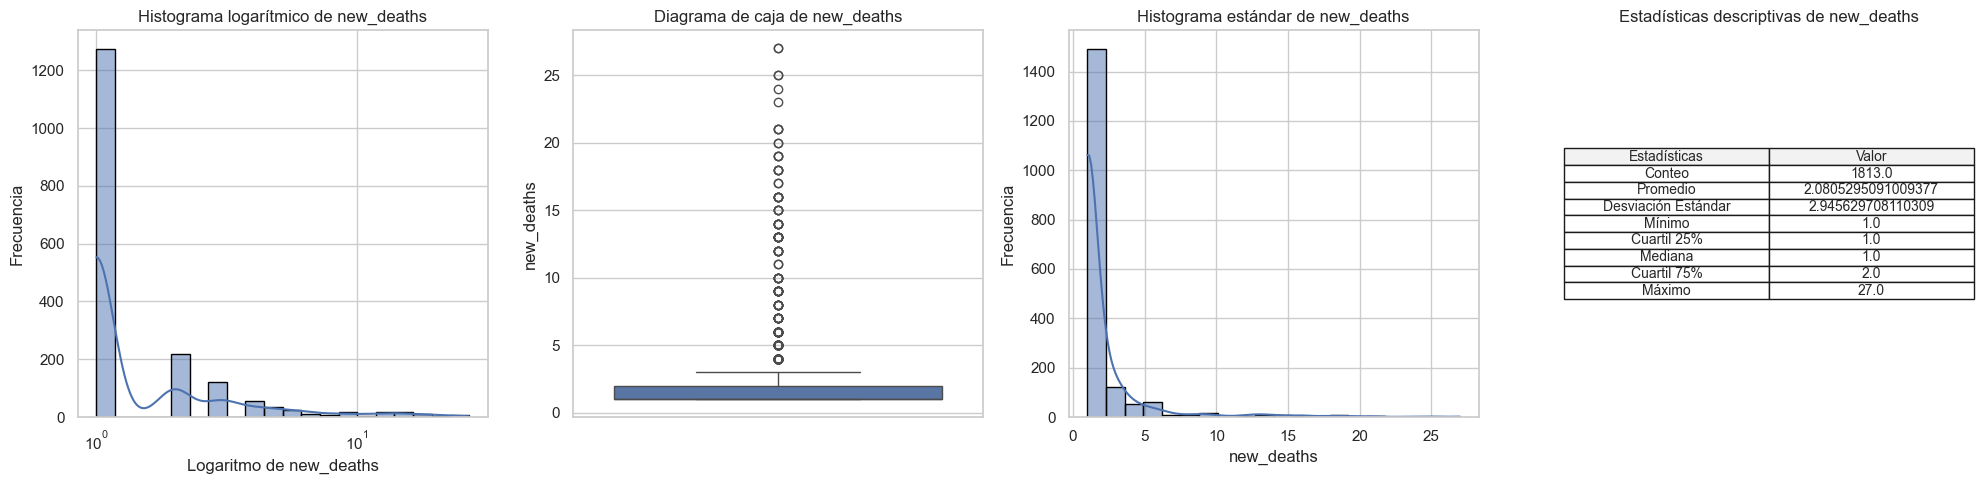

In [161]:
plot_analysis(df_mdp, 'new_deaths')

**Análisis de la variable `cumulative_deaths`**
| **Histograma logarítmico de `cumulative_deaths`** | **Diagrama de caja de `cumulative_deaths`** | **Histograma estándar de `cumulative_deaths`** |
| ------------------ | ------------------ | ------------- |
| El histograma logarítmico muestra la distribución de muertes acumulativas en los municipios. La transformación logarítmica se aplicó para mejorar la visualización. | El diagrama de caja presenta la variabilidad en el número acumulado de muertes en los municipios. Se observa una amplia gama de valores acumulativos, con algunos municipios que tienen valores atípicos significativamente más altos. | El histograma estándar muestra la distribución de muertes acumulativas en los municipios sin la transformación logarítmica. Algunos municipios tienen números acumulativos significativamente más altos que otros. |

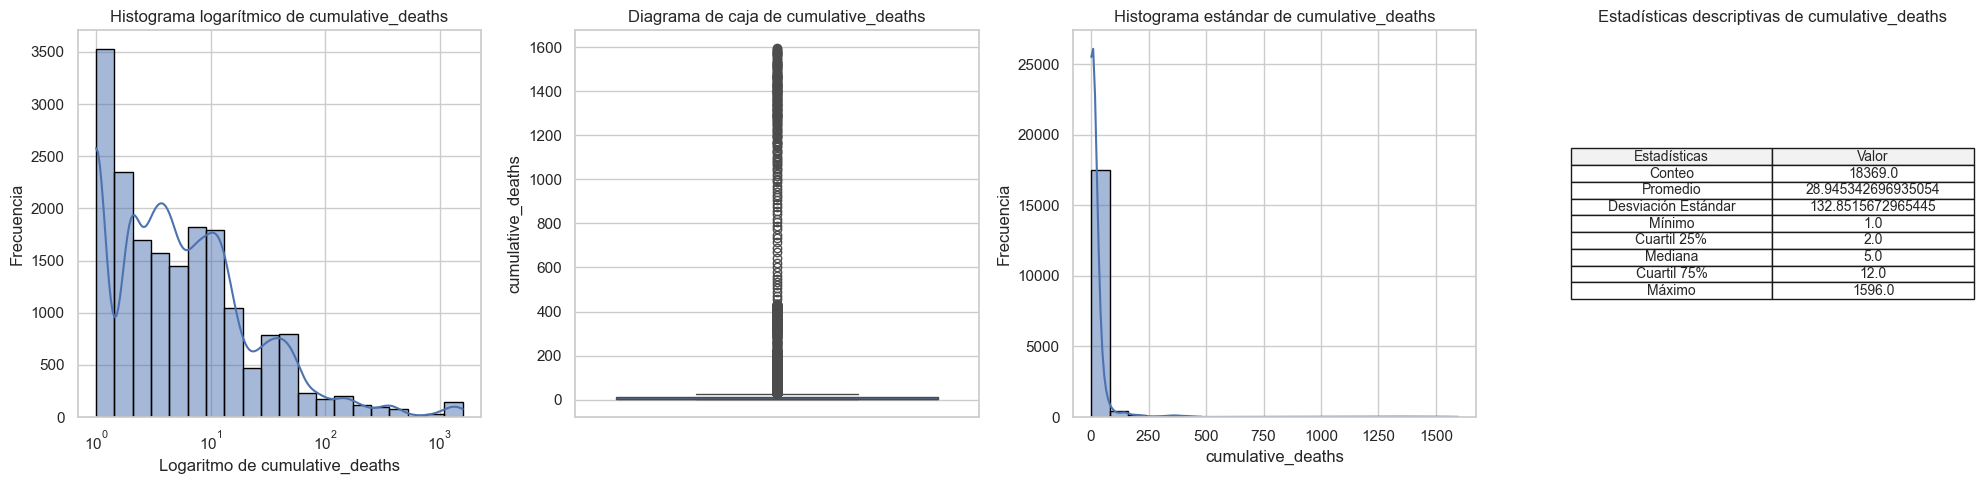

In [162]:
plot_analysis(df_mdp, 'cumulative_deaths')

### Datos Cualitativos

#### Uso y calculo de registros por departamento y municipio

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px" class="tg"><thead><tr><th style="background-color:#34696D;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Cantidad total de datos de Registros de Municipios: 112</th><th style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></th><th style="background-color:#34696d;border-color:#000000;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal" colspan="2">Cantidad total de datos de Registros de Departamentos: 17</th></tr></thead><tbody><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Municipality</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Count</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">name_department</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Count</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">MAZATENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CUYOTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">JALAPA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ACATENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">TOTONICAPAN</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PATZICIA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">SOLOLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">POCHUTA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">...</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">JOYABAJ</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PETEN</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CUNEN</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">QUICHE</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">PATZITE</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">HUEHUETENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CHICHICASTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">RETALHULEU</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">GENOVA</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#ffffff;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">1</td></tr><tr><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">112</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">17</td></tr></tbody></table>

**Observaciones:**
- En el análisis de Registros de Municipios se observa un total de 112 municipios distintos.
- En el análisis de Registros de Departamentos, se identifican 17 departamentos diferentes.

Ambas gráficas son similares, puesto que solo existe un registro para cada uno de los departamento y cada municipio


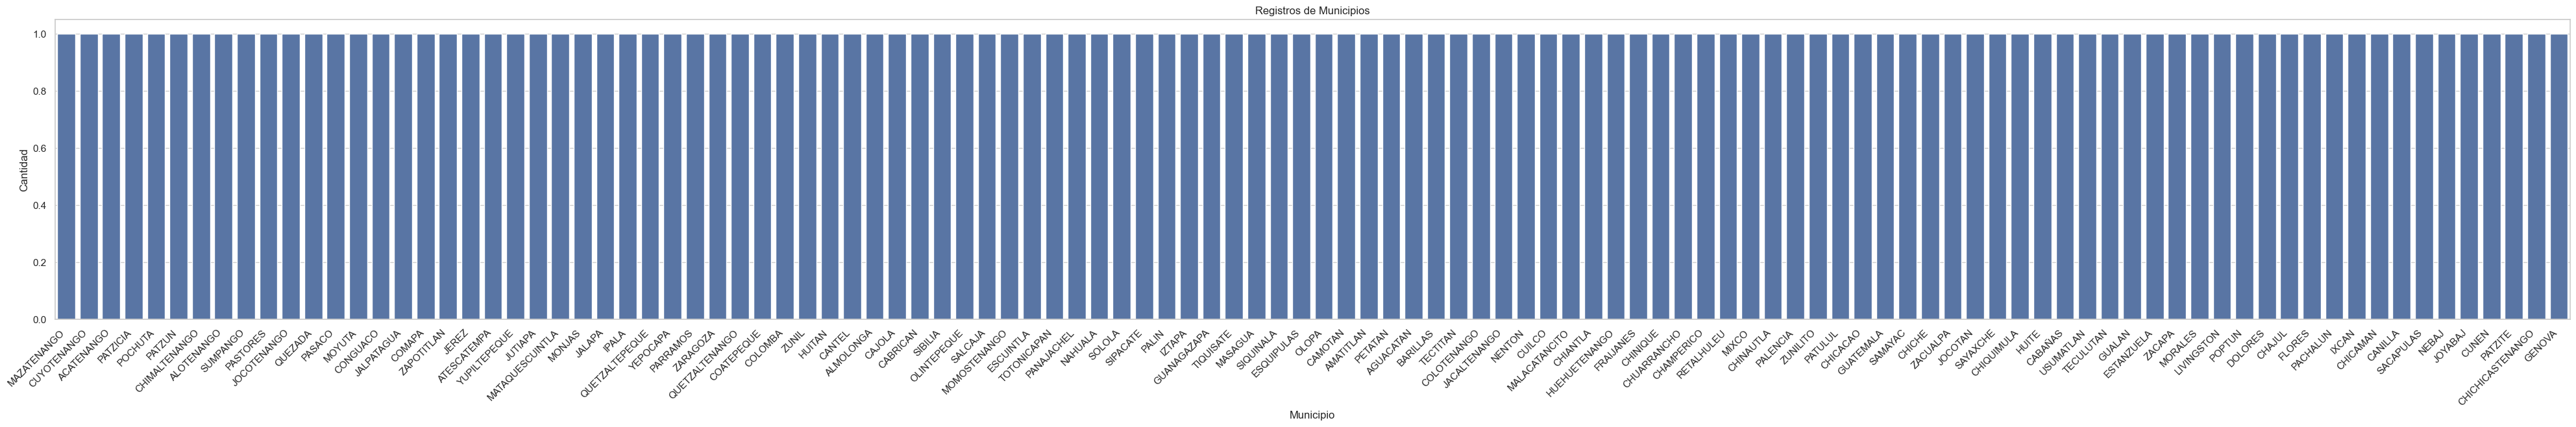

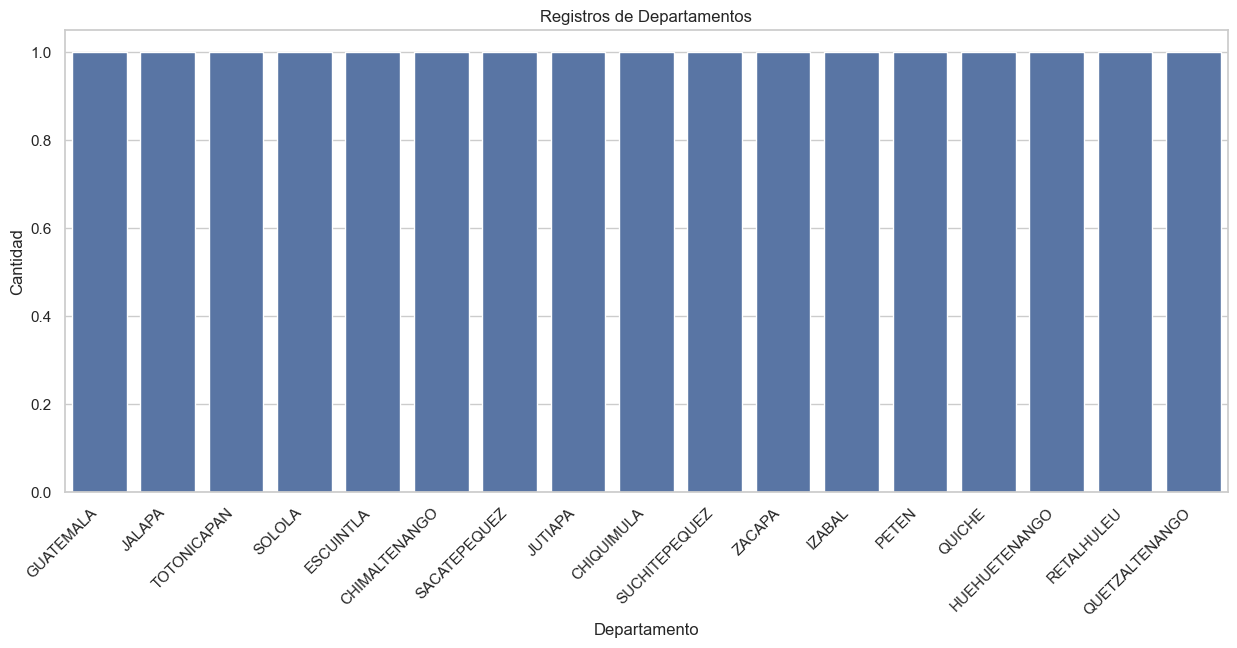

In [163]:
# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_municipality, 'municipality', 'Municipio', 'Cantidad', 'Registros de Municipios', True)

# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_department, 'name_department', 'Departamento', 'Cantidad', 'Registros de Departamentos')

## **EDA Multivariable**

### Datos cuantitativos

#### Muertes acumuladas por Municipio segun fechas

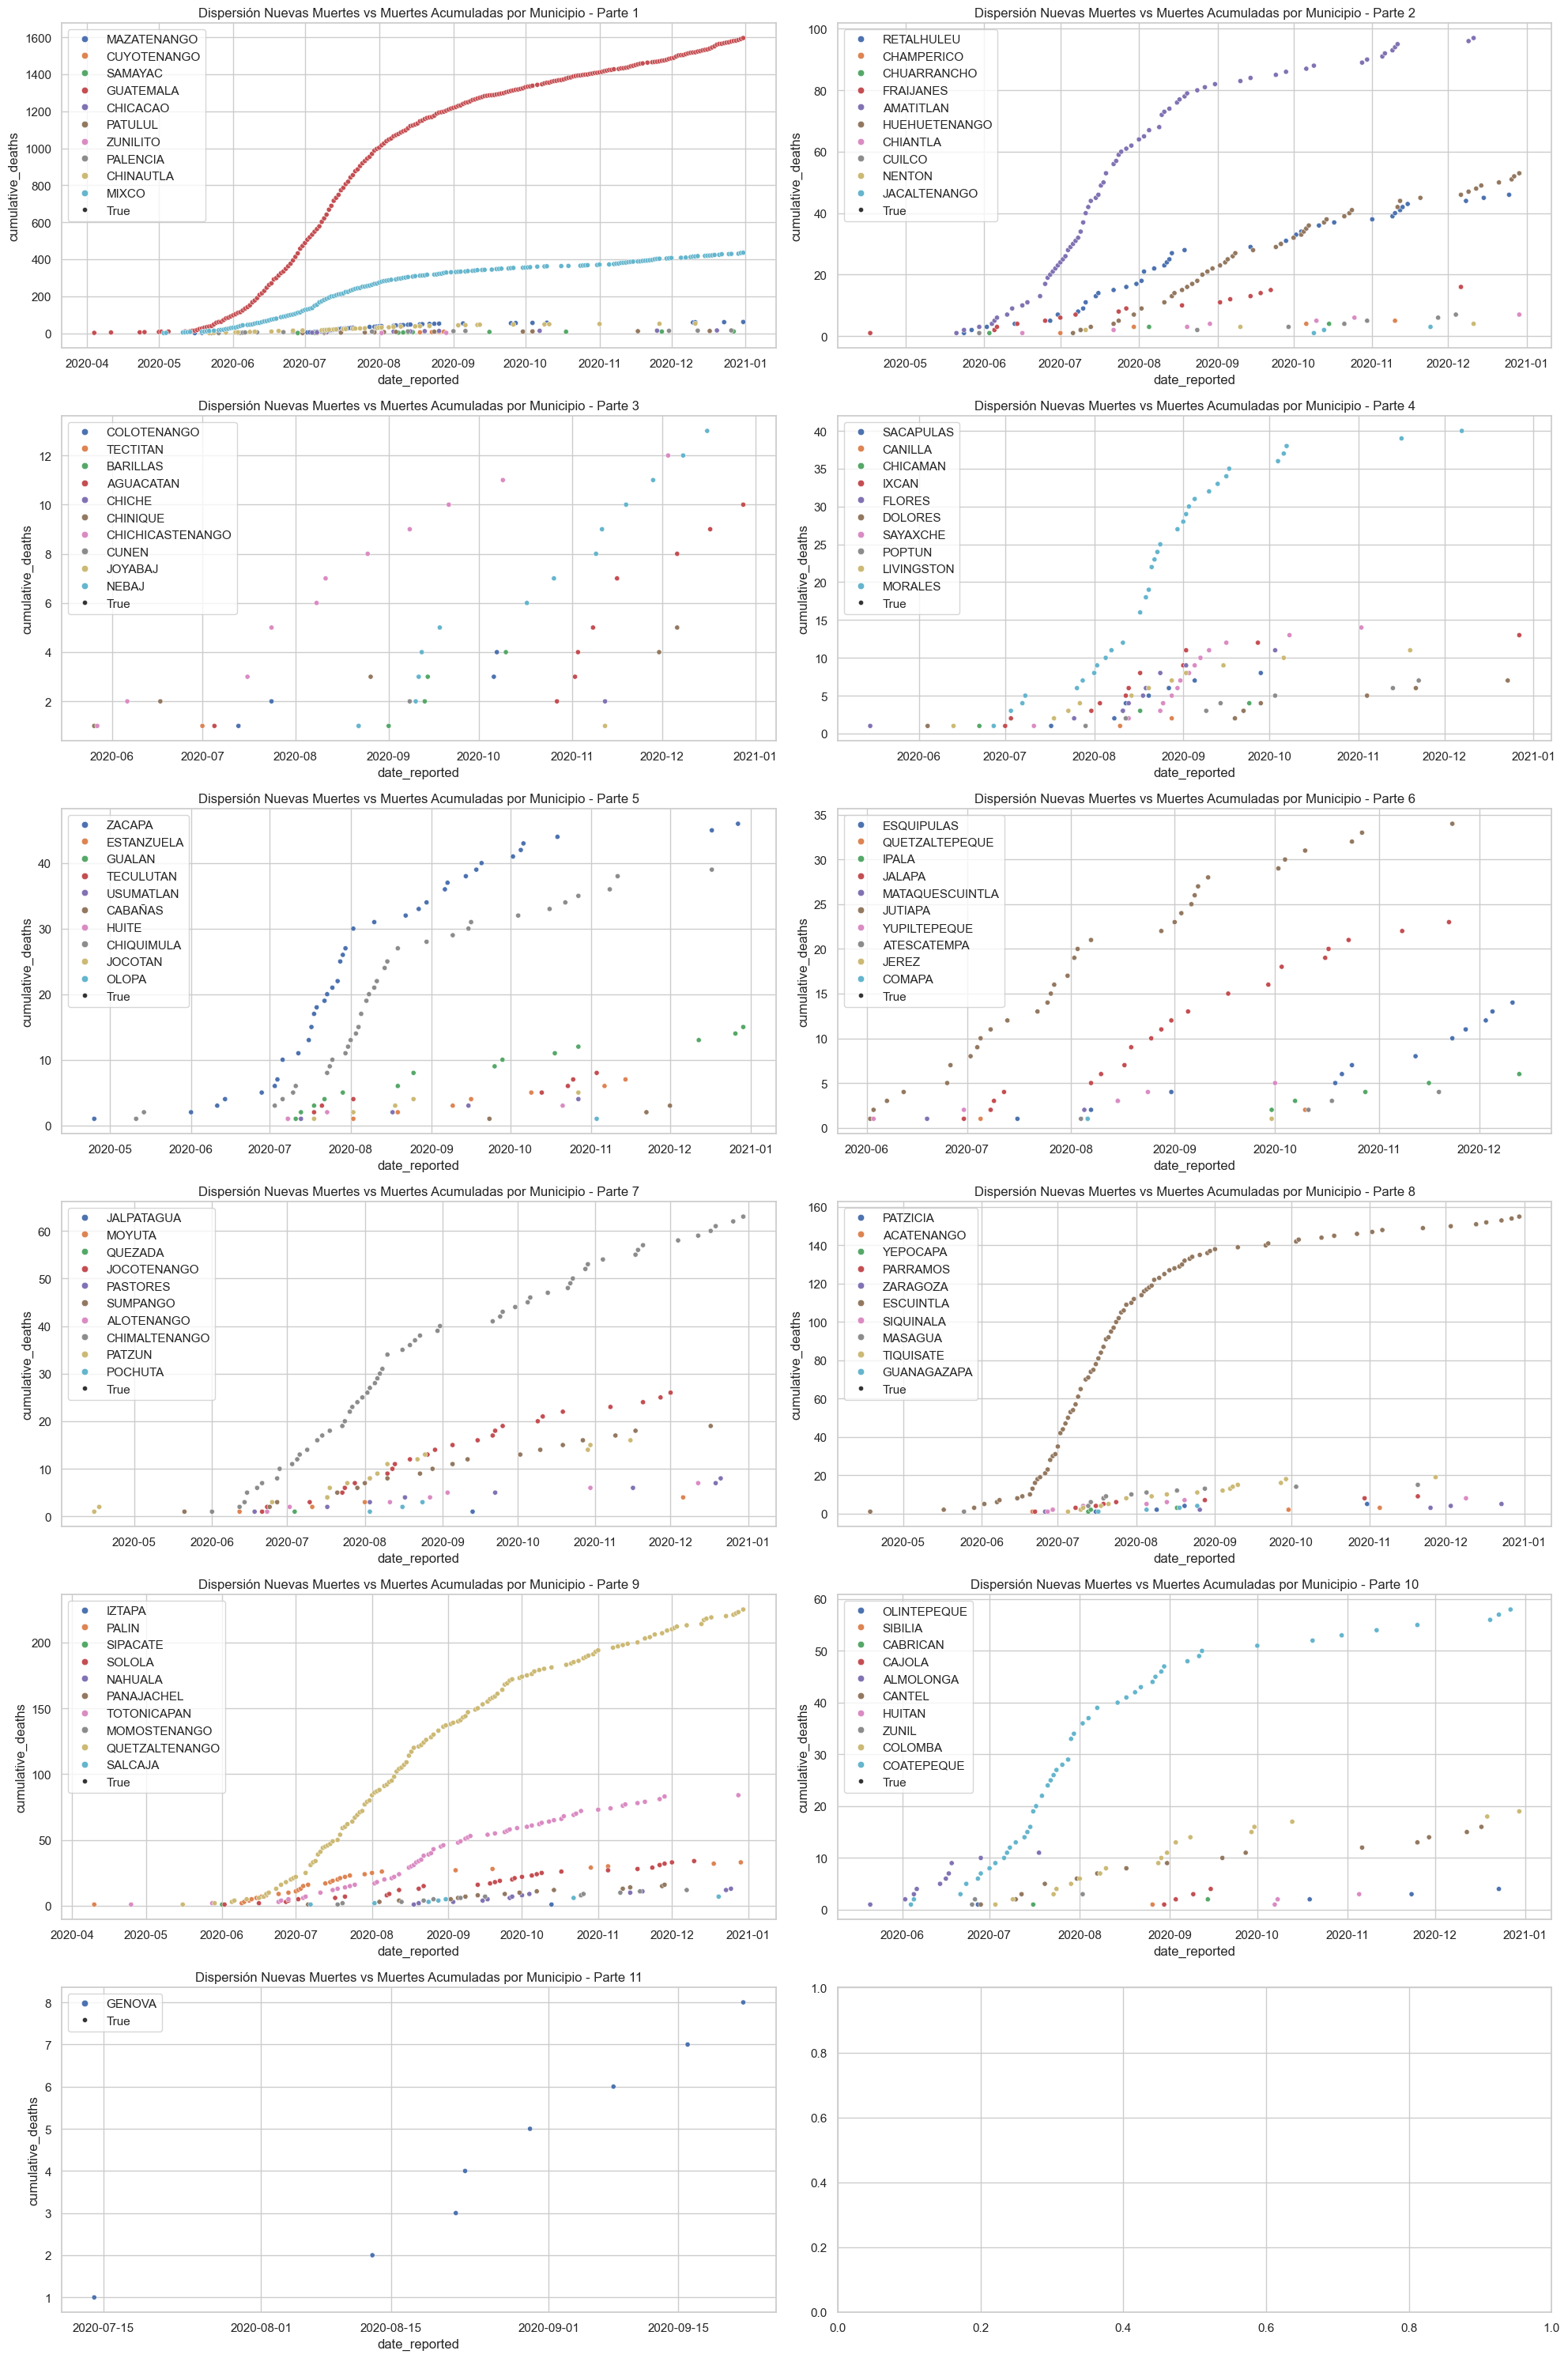

In [164]:
scatter_plot_multi(df_mdp_gt_0, 'date_reported', 'cumulative_deaths', 'municipality', 'Dispersión Nuevas Muertes vs Muertes Acumuladas por Municipio', size=True, points_per_subplot=10, subplots_per_row=2)

#### Muertes acumuladas por Departamento según fechas

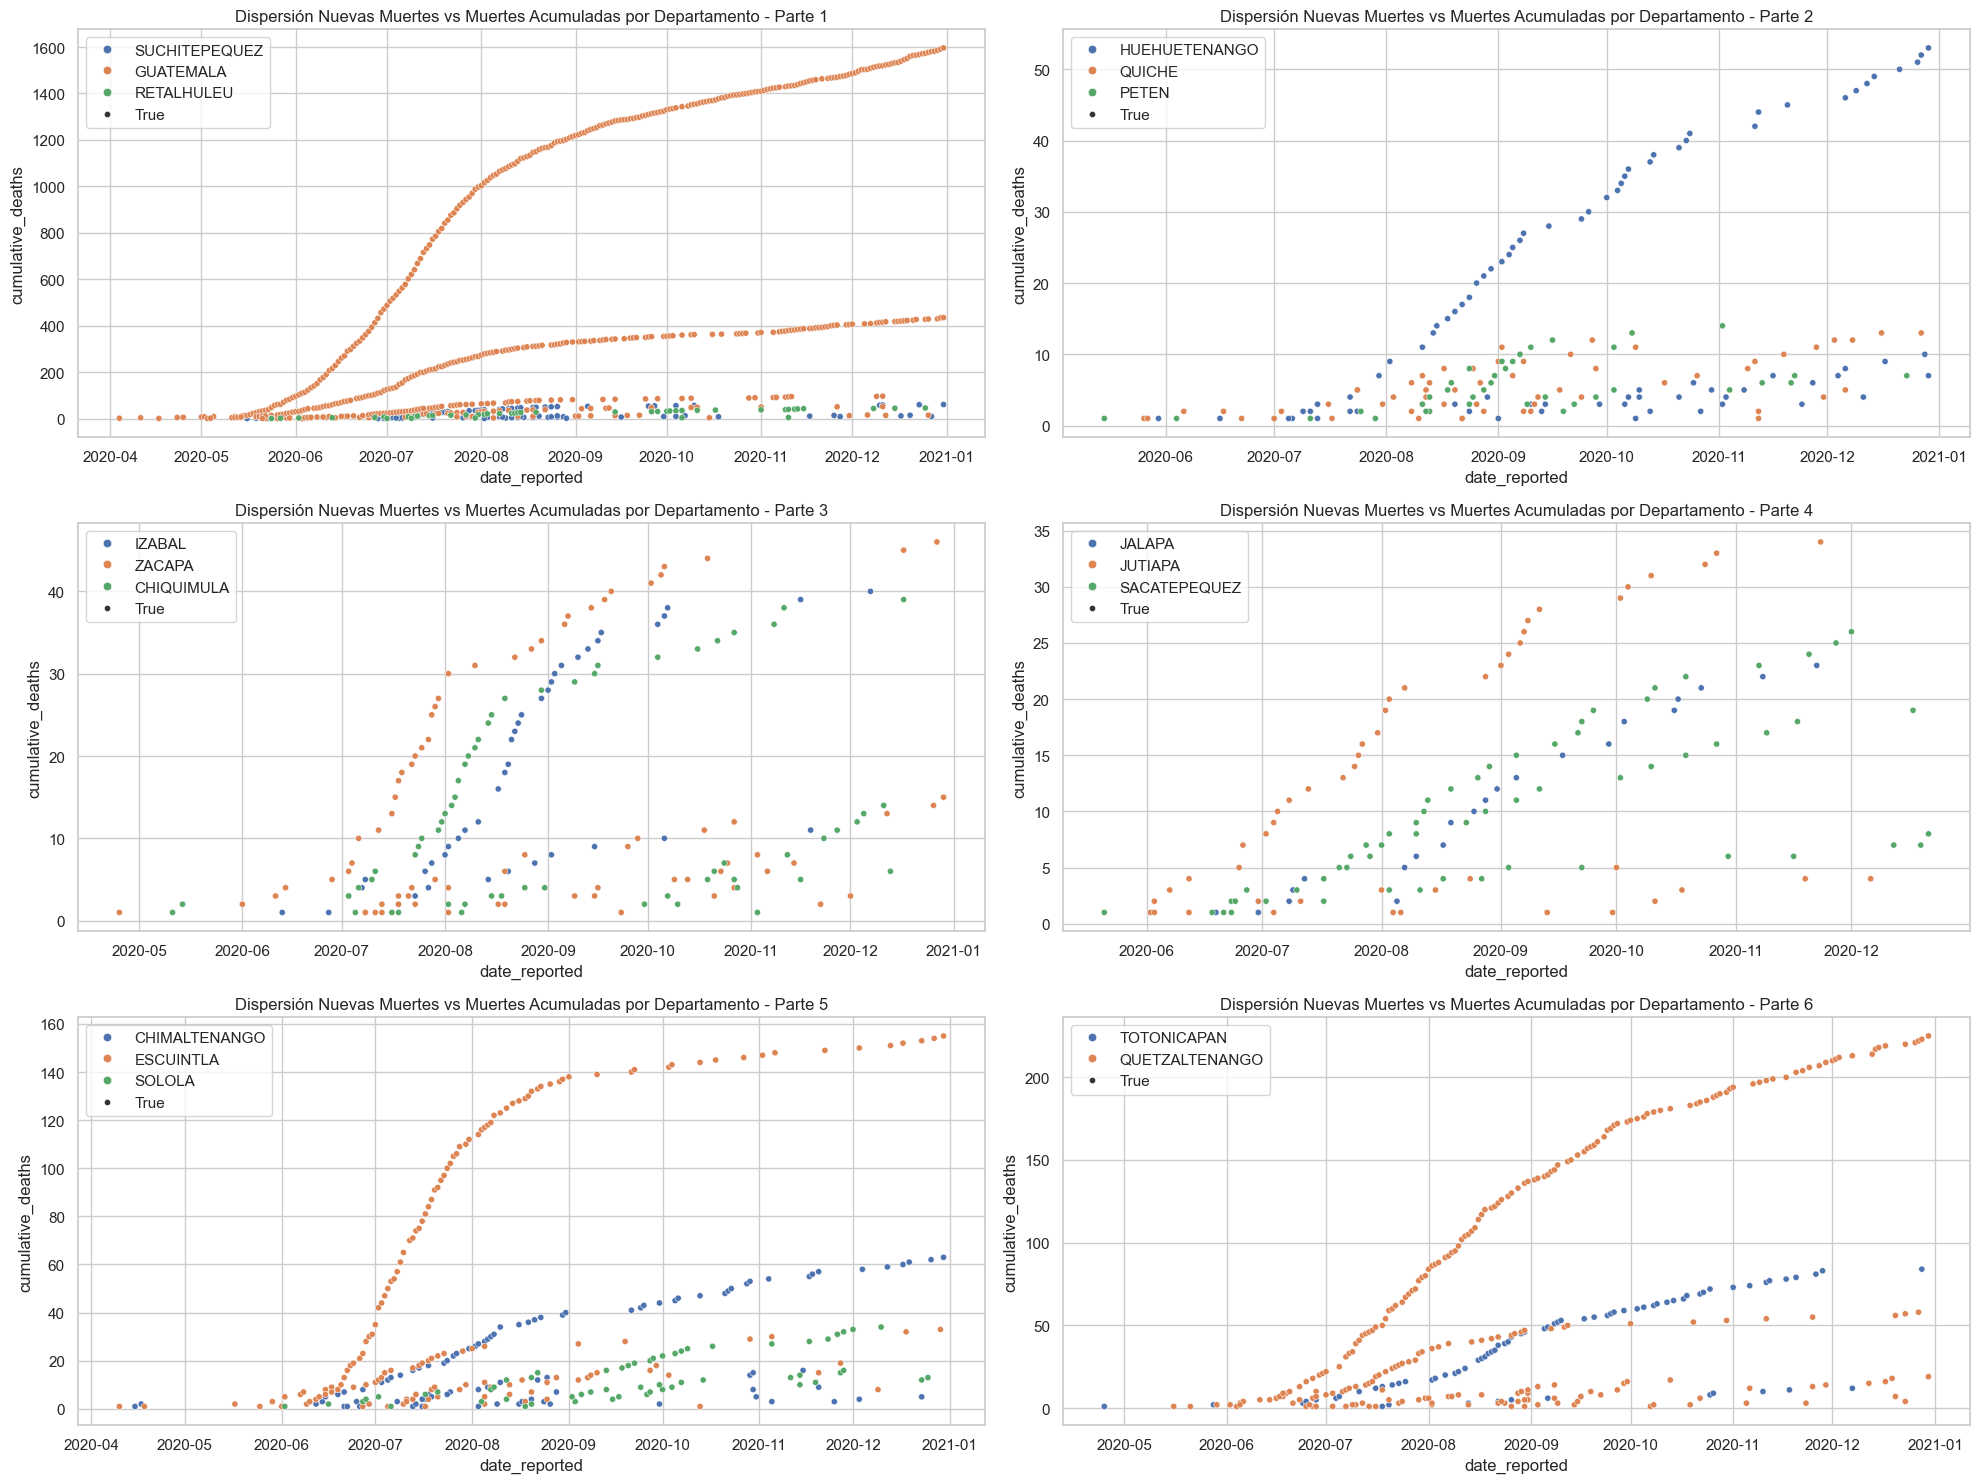

In [165]:
scatter_plot_multi(df_mdp_gt_0, 'date_reported', 'cumulative_deaths', 'name_department', 'Dispersión Nuevas Muertes vs Muertes Acumuladas por Departamento', size=True, points_per_subplot=3, subplots_per_row=2)

#### Nuevas muertes vs Muertes acumuladas por municipios

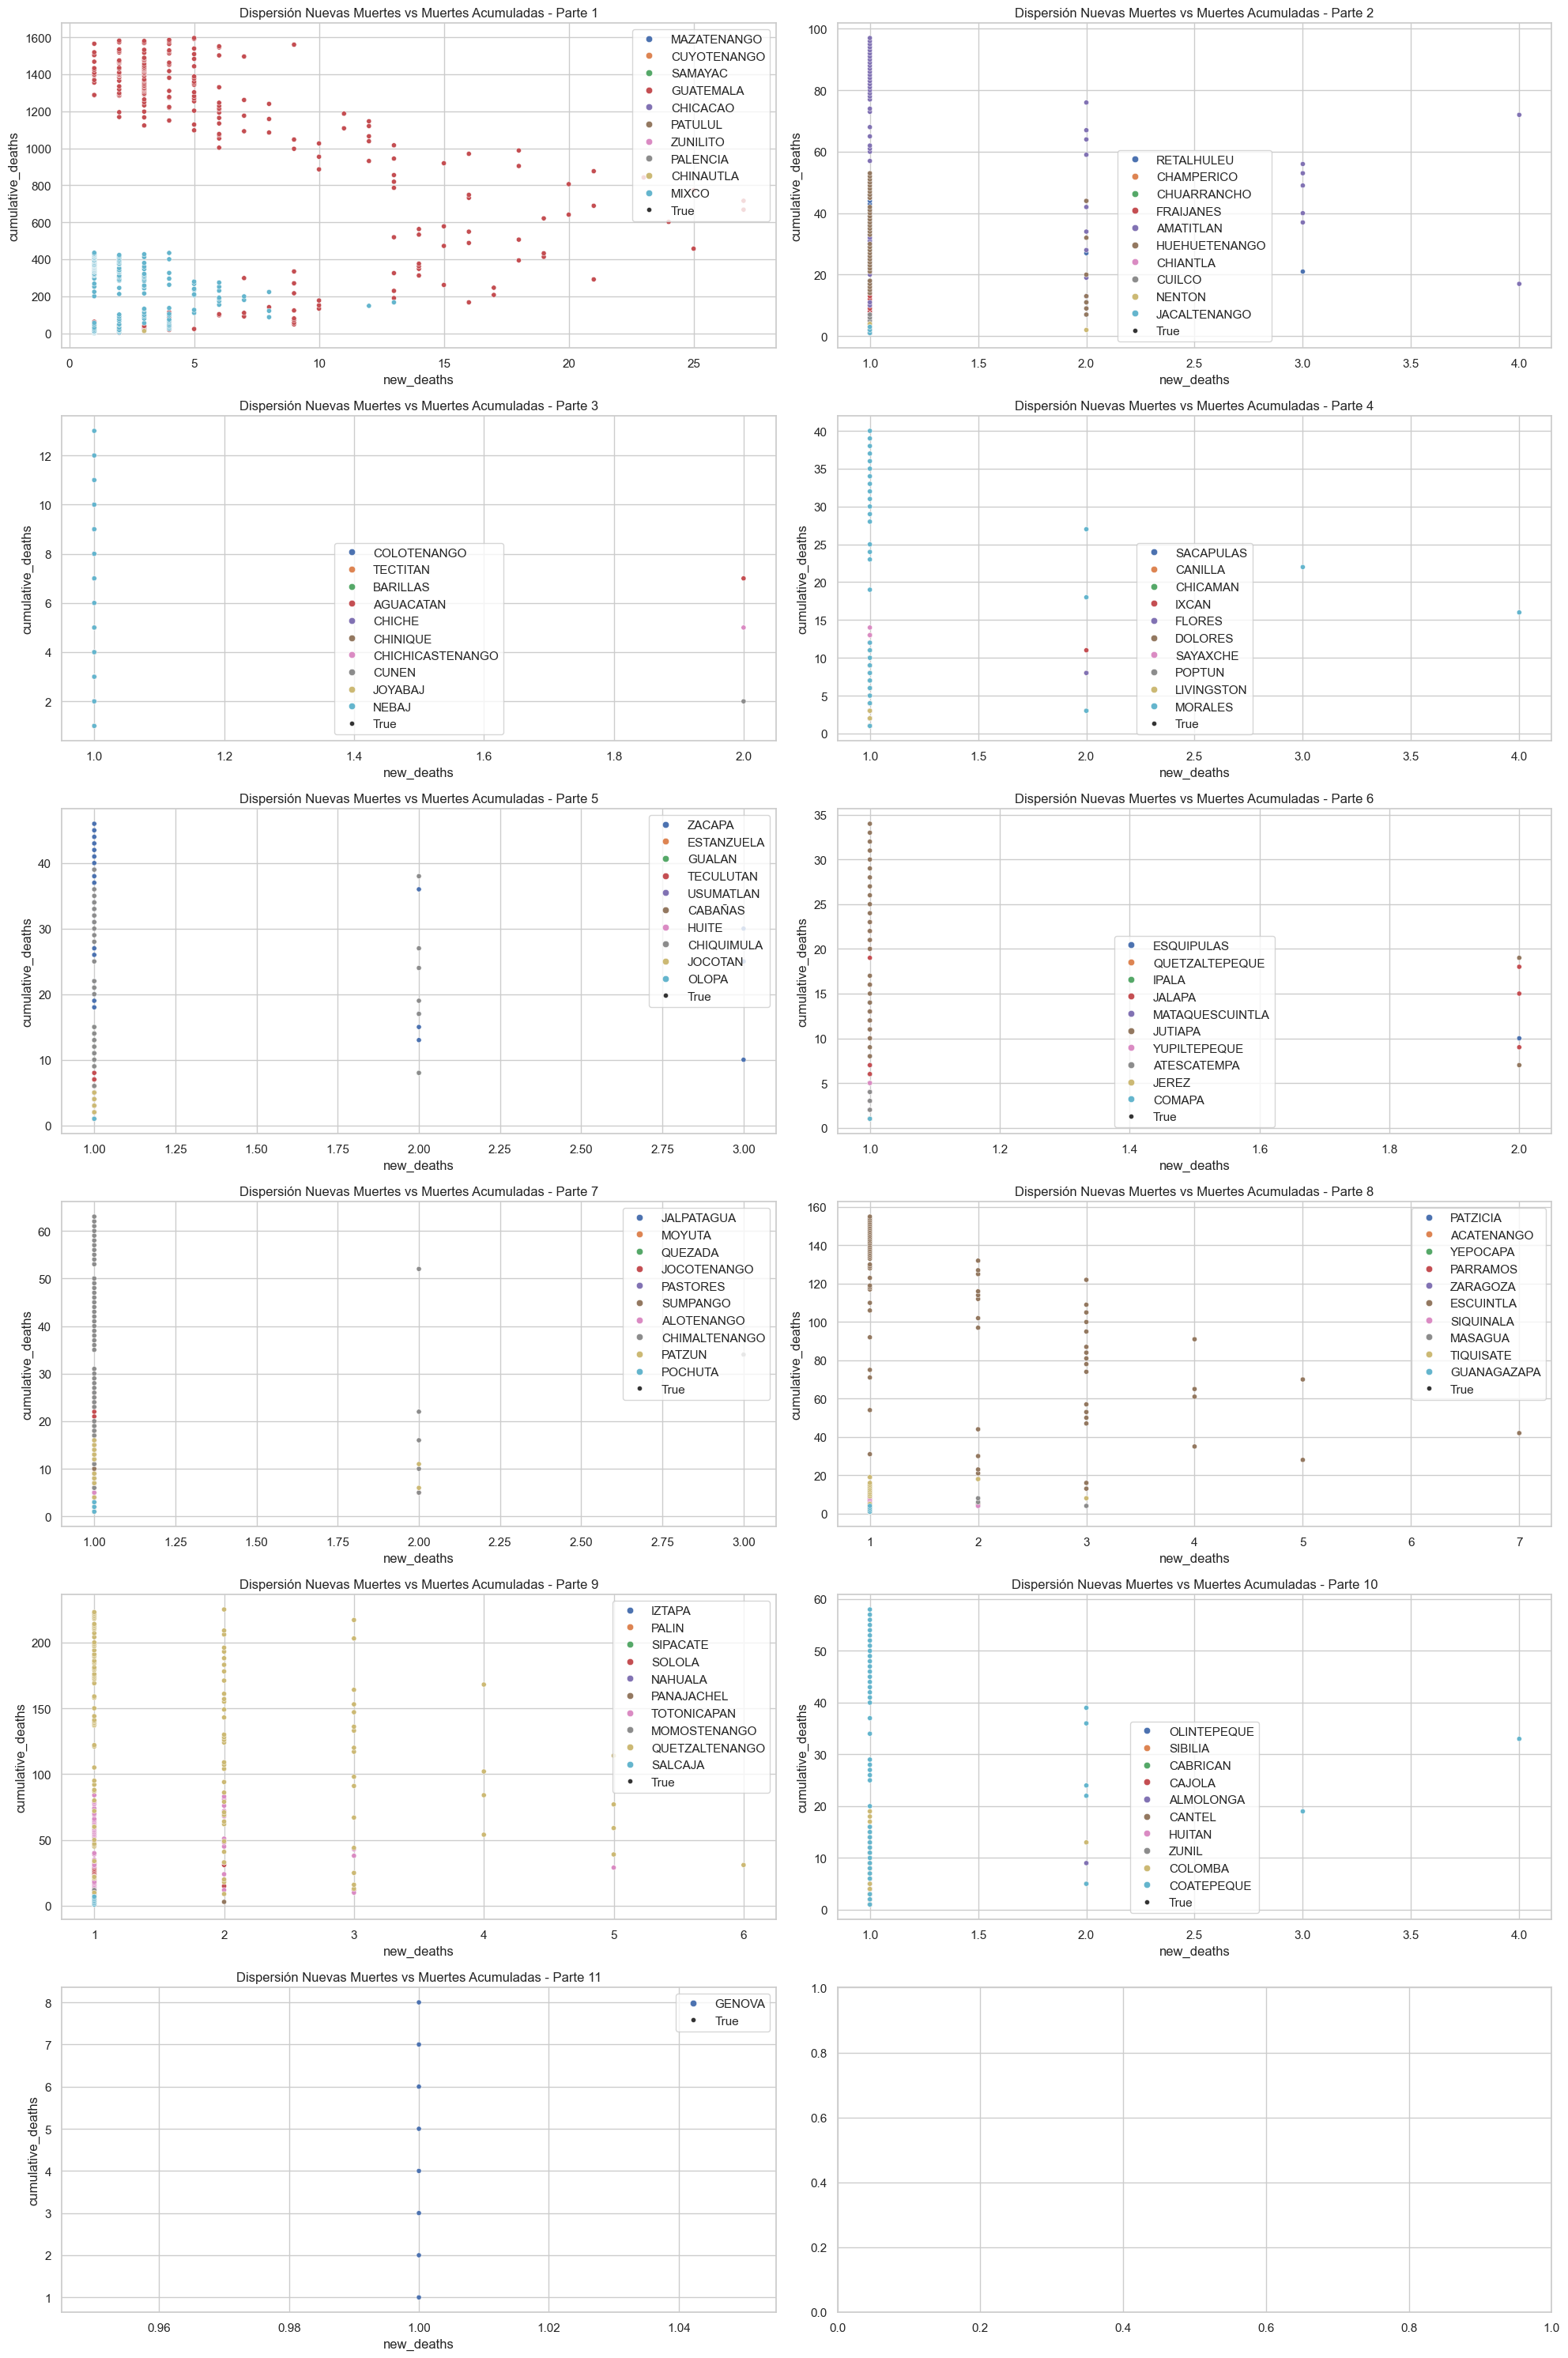

In [166]:
scatter_plot_multi(df_mdp_gt_0, 'new_deaths', 'cumulative_deaths', 'municipality', 'Dispersión Nuevas Muertes vs Muertes Acumuladas', size=True, points_per_subplot=10, subplots_per_row=2)

#### Nuevas muertes vs Muertes acumuladas por Departamentos

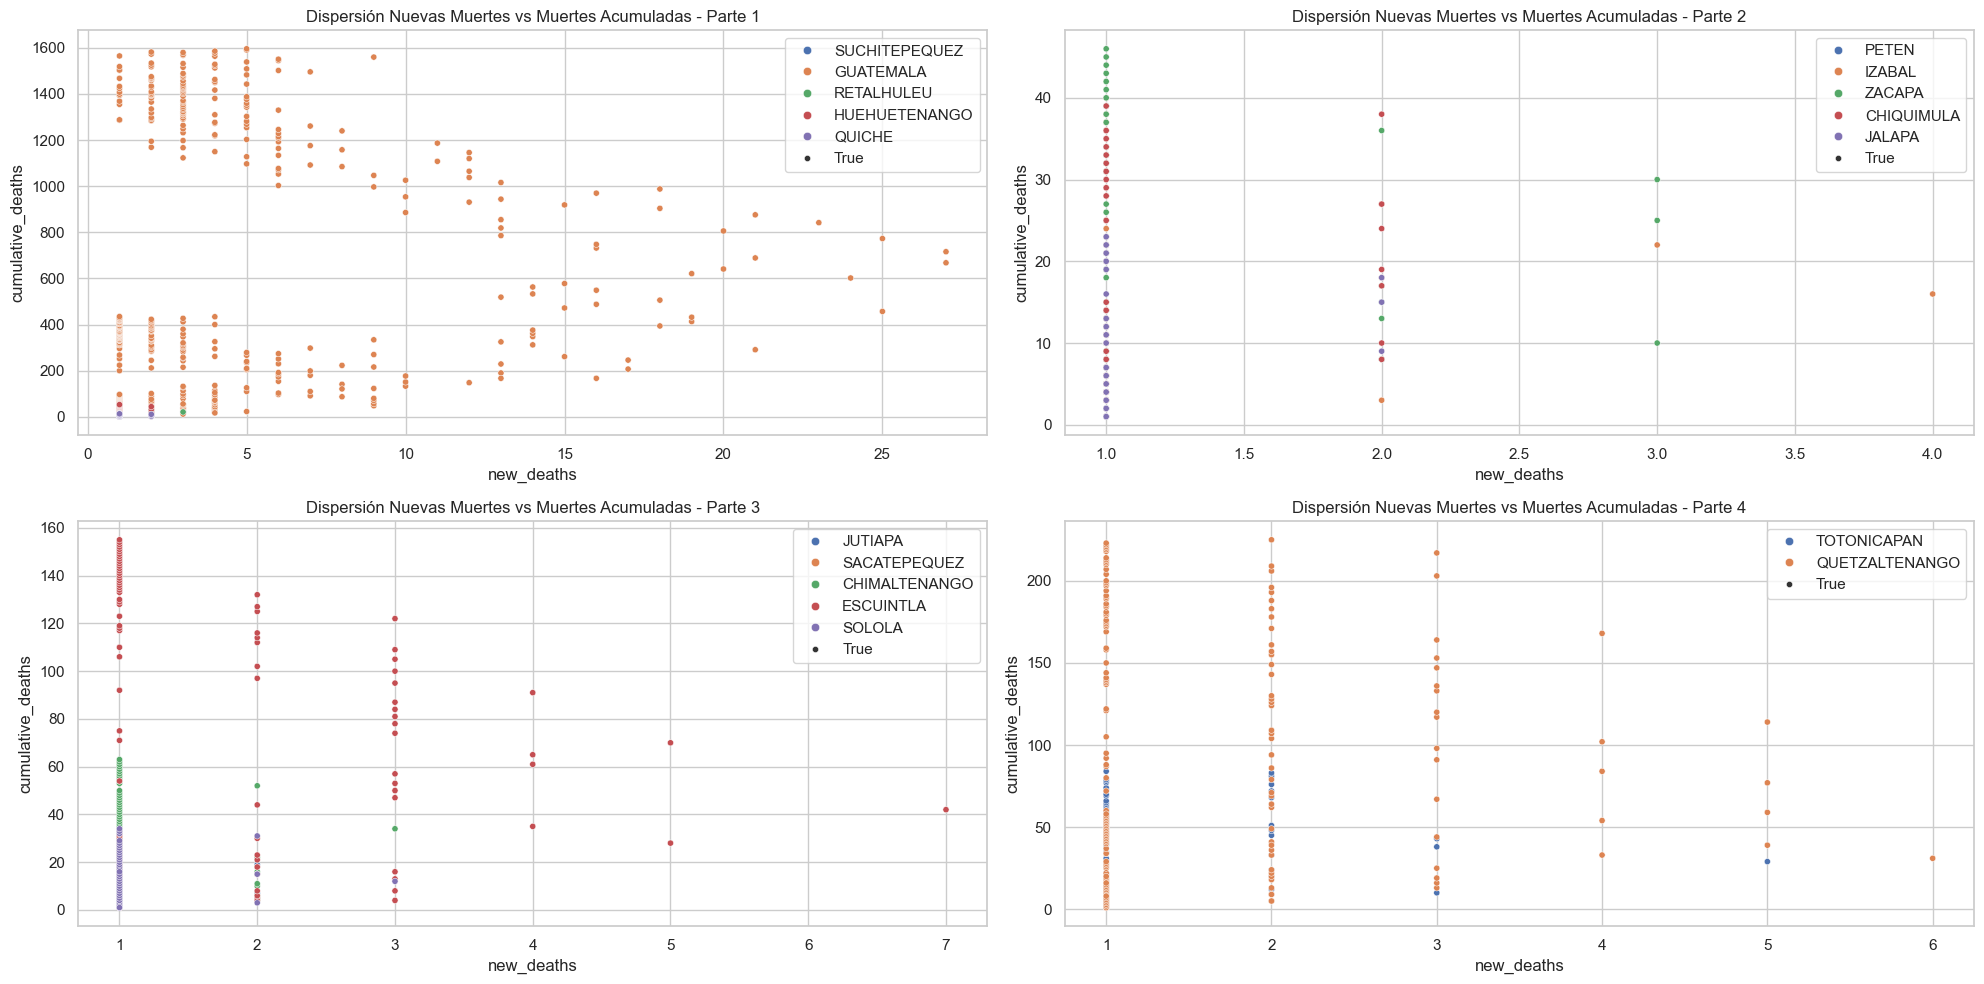

In [167]:
scatter_plot_multi(df_mdp_gt_0, 'new_deaths', 'cumulative_deaths', 'name_department', 'Dispersión Nuevas Muertes vs Muertes Acumuladas', size=True, points_per_subplot=5, subplots_per_row=2)

#### Departamento vs Poblacion

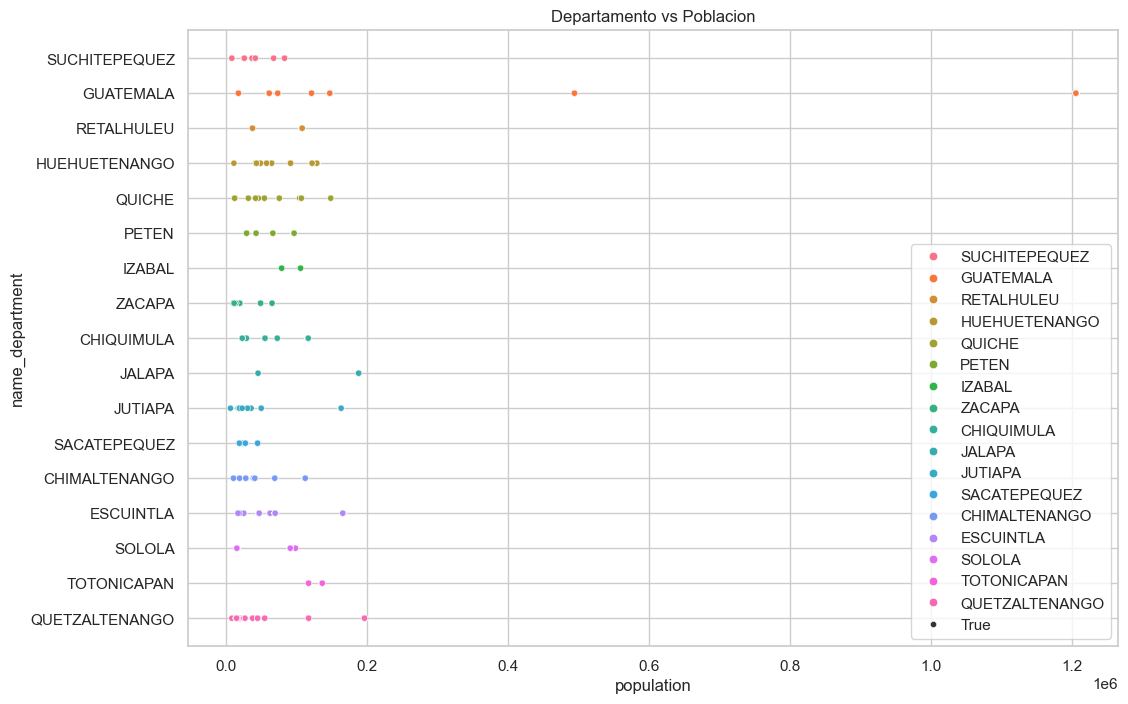

In [168]:
scatter_plot(df_mdp_gt_0, 'population', 'name_department', 'name_department', 'Departamento vs Poblacion', True)

#### Municipio vs Población

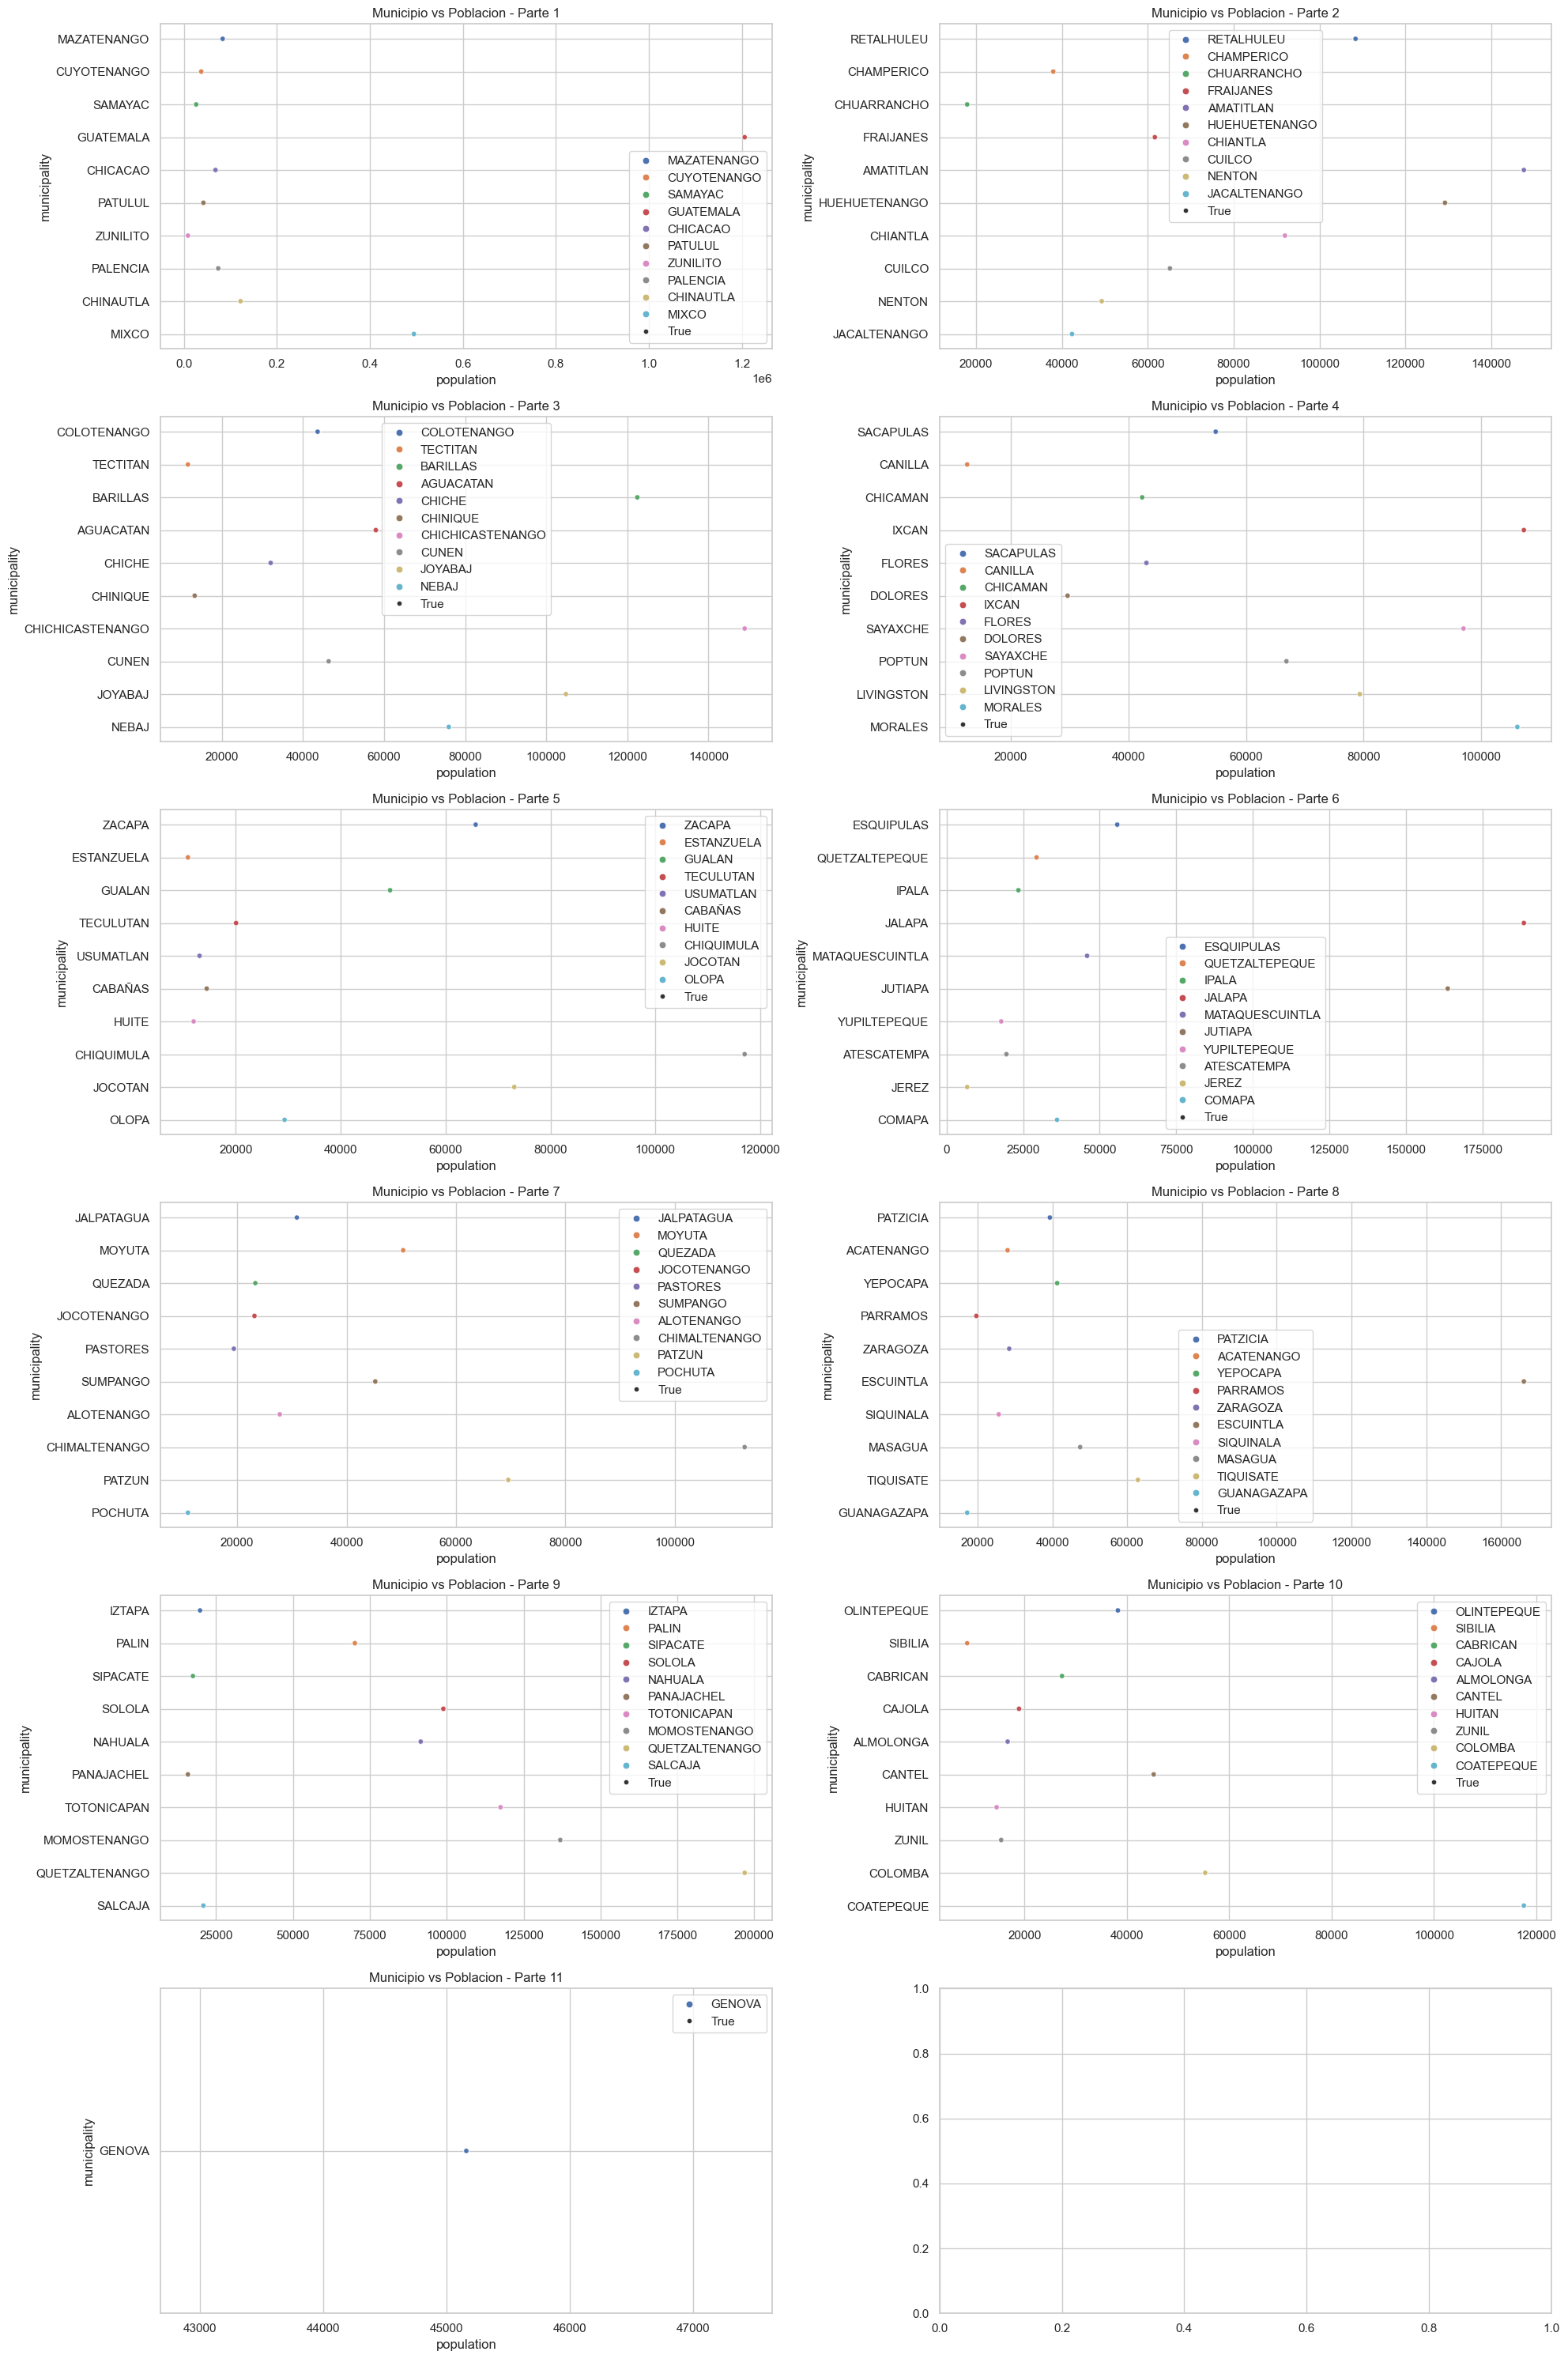

In [169]:
scatter_plot_multi(df_mdp_gt_0, 'population', 'municipality', 'municipality', 'Municipio vs Poblacion', size=True, points_per_subplot=10, subplots_per_row=2)

### Datos cualitativos

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px" class="tg"><thead><tr><th style="background-color:#6665cd;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Cantidad total de datos de Conteo de Registros de Municipios por Departamento: 112</th><th style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></th><th style="background-color:#6665CD;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Cantidad total de datos de Conteo de Registros de Municipios por Departamento: 112</th></tr></thead><tbody><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Departamento</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Municipios</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Departamento</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">Municipio</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUICHE</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">14</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JALAPA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">3</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUETZALTENANGO</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">13</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SOLOLA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">3</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">HUEHUETENANGO</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">11</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">IZABAL</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JUTIAPA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">11</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">RETALHULEU</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">ESCUINTLA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">8</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">CHIMALTENANGO</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">352</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTONICAPAN</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">RETALHULEU</td><td style="background-color:#cbcefb;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal">140</td></tr><tr><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">112</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TOTAL</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">112</td></tr></tbody></table>

#### **Departamento vs Cantidad de Municipios**

**Observaciones:**
En el Análisis de Registros de Municipios por Departamento, QUICHE tiene la mayor frecuencia con 14 registros, seguido por QUETZALTENANGO con 13. Y los cinco departamentos con mayor frecuencia son:
1. QUICHE: 14 registros
2. QUETZALTENANGO: 13 registros
3. HUEHUETENANGO: 11 registros
4. JUTIAPA: 11 registros
5. ESCUINTLA: 8 registros

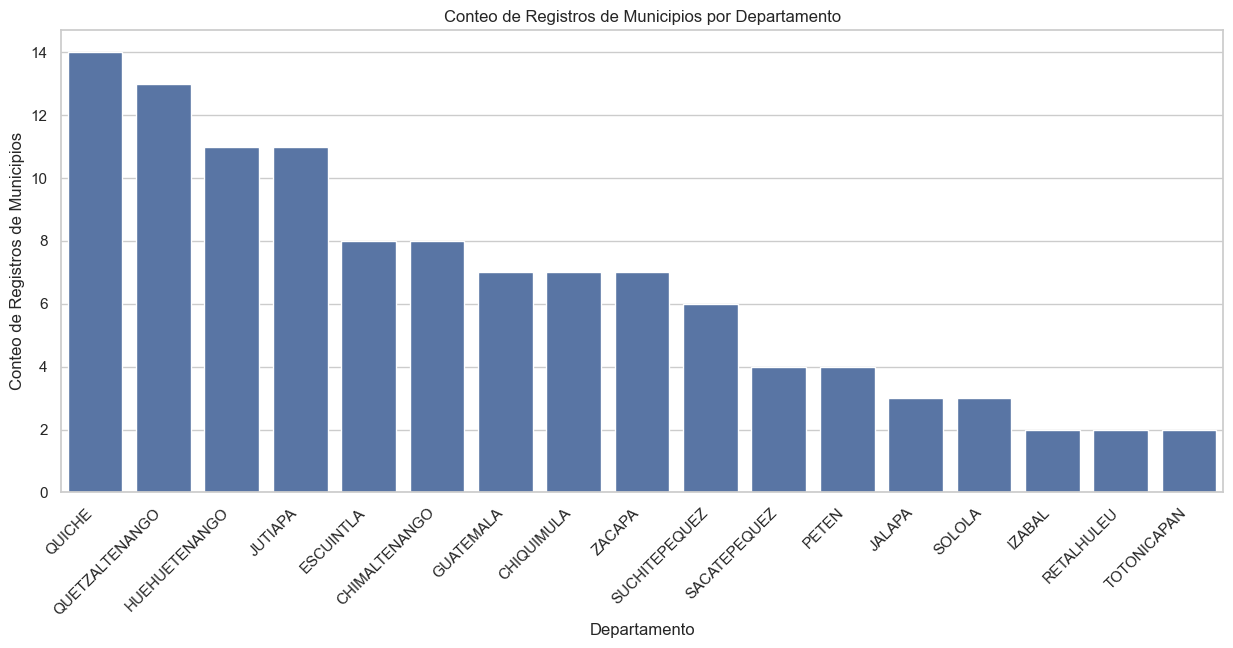

In [170]:
# Generar diagrama de barras para departamentos: cantidad de veces que aparecen en los casos de Covid
generate_count_plot(df_municipality, 'name_department', 'Departamento', 'Conteo de Registros de Municipios', 'Conteo de Registros de Municipios por Departamento')

#### **Municipios vs Población**

**Análisis:**
El análisis de la población por municipio muestra un total de 7,554,936 personas distribuidas en varios municipios. El municipio más poblado es GUATEMALA con una población de 1,205,668 personas, seguido por MIXCO con 494,561 personas. En comparación, los municipios menos poblados son SIBILIA, ZUNILITO, PATZITE, PETATAN y JEREZ, con poblaciones que oscilan entre 8,766 y 6,706 personas.

Este análisis proporciona información valiosa sobre la distribución de la población en diferentes municipios. La concentración de población en GUATEMALA y otros municipios más grandes puede tener implicaciones significativas para la planificación y asignación de recursos.

**Listado de Municipios**

**Top 5:**
1. GUATEMALA: 1,205,668 personas
2. MIXCO: 494,561 personas
3. QUETZALTENANGO: 196,867 personas
4. JALAPA: 188,522 personas
5. ESCUINTLA: 166,078 personas

**Peores 5:**
1. SIBILIA: 8,766 personas
2. ZUNILITO: 8,724 personas
3. PATZITE: 7,462 personas
4. PETATAN: 6,861 personas
5. JEREZ: 6,706 personas

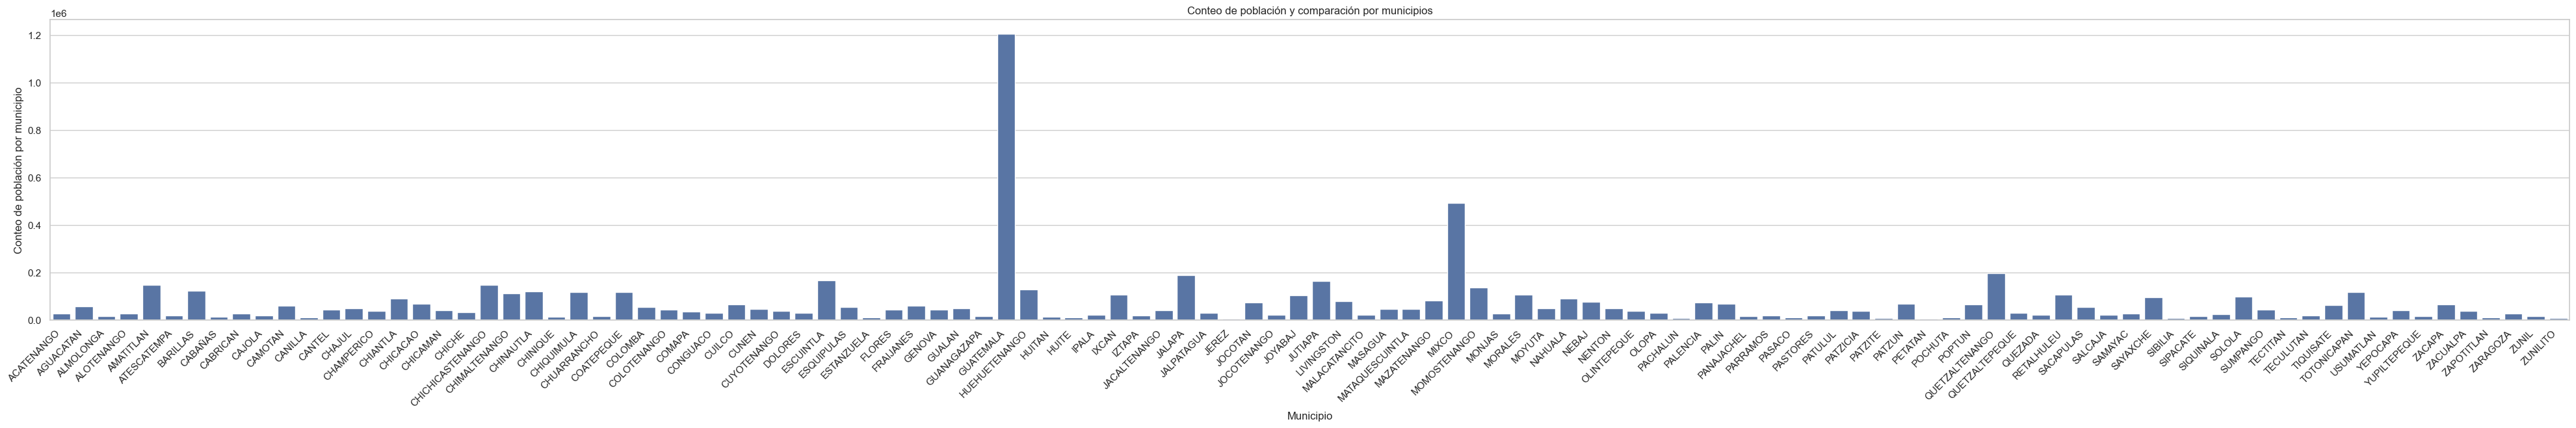

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


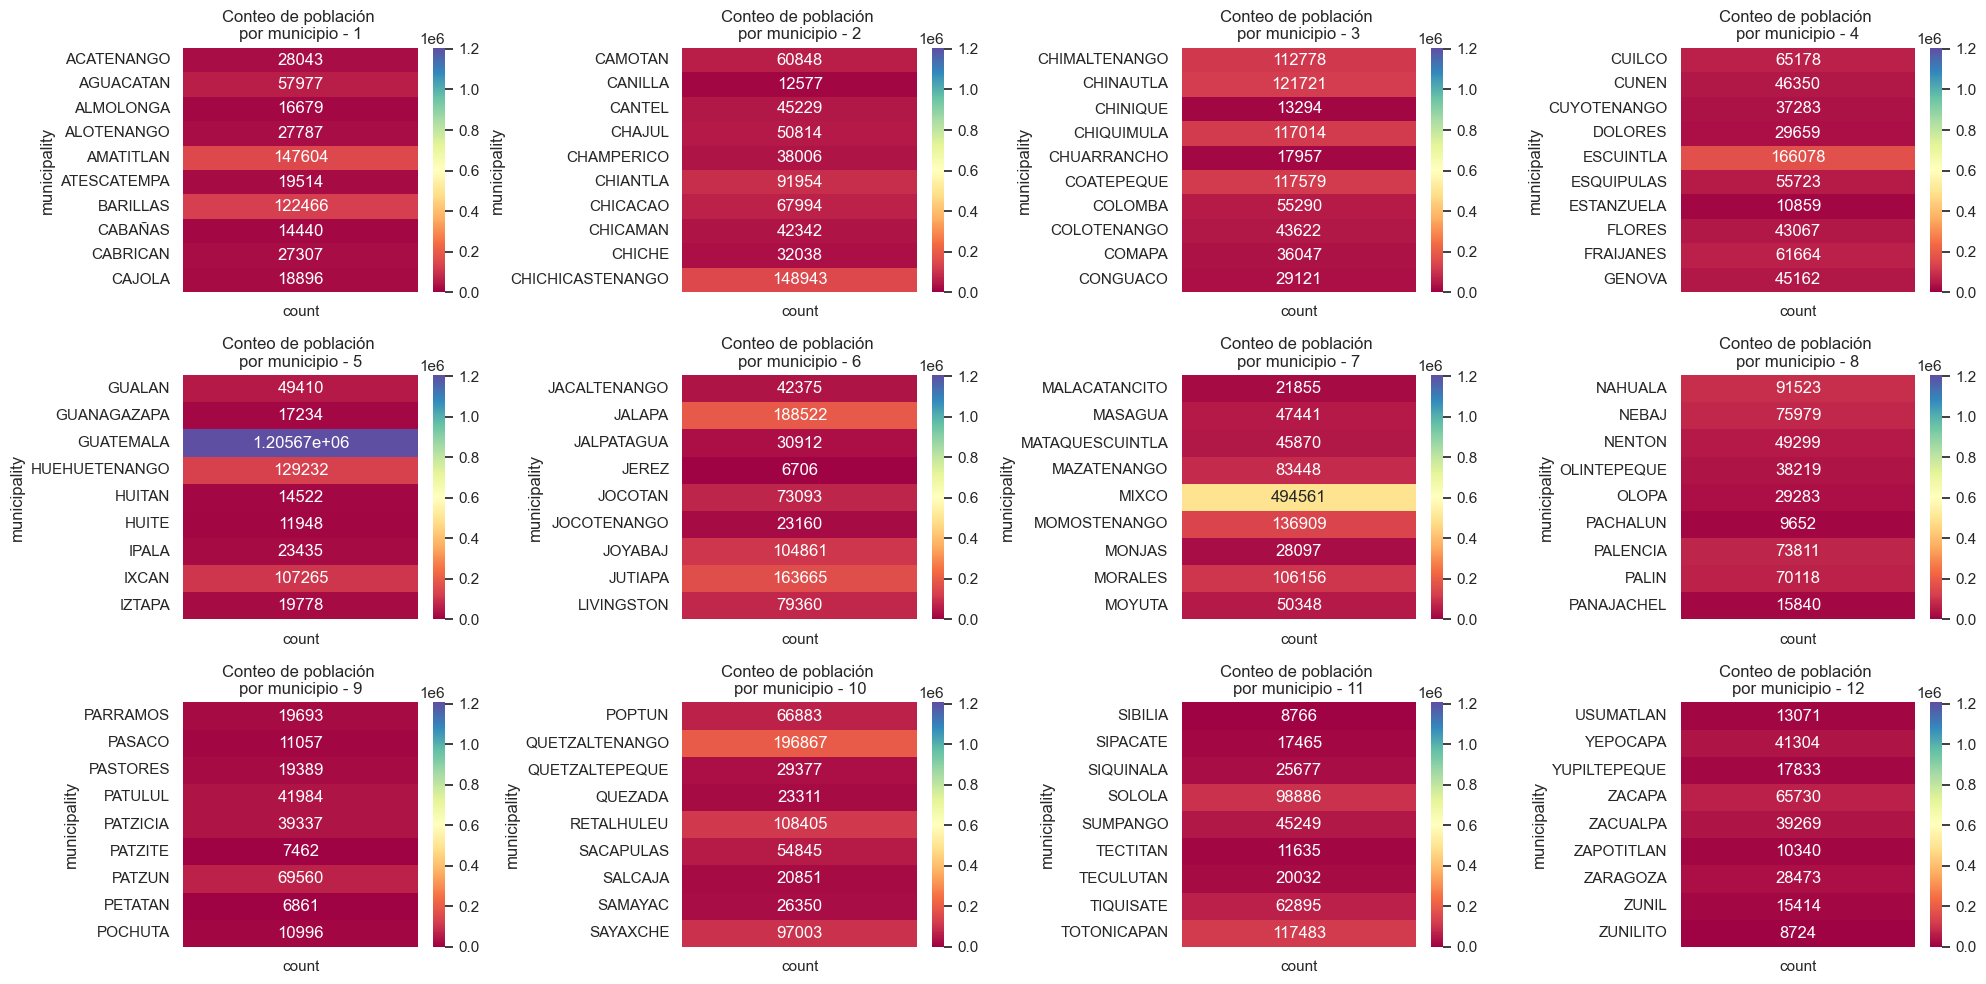

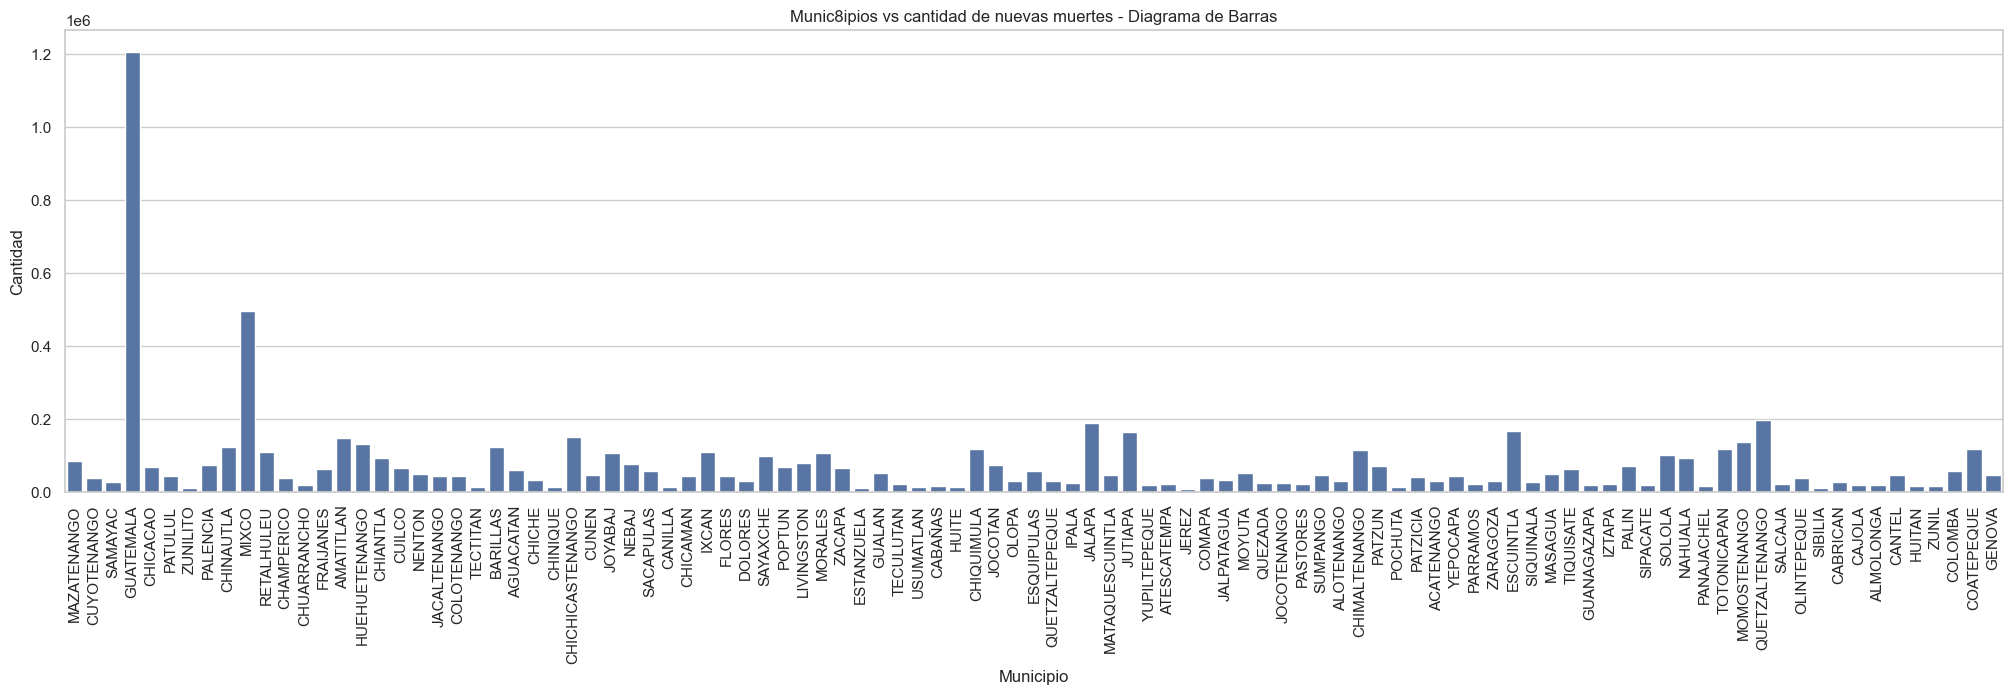

In [171]:
generate_sum_plot(df_municipality, 'population','municipality', 'Municipio', 'Conteo de población por municipio', 'Conteo de población y comparación por municipios', True)
generate_heatmaps(df_municipality, 'population', 'municipality', 'Municipio','Conteo de población \npor municipio', 'Conteo de población y comparación por municipios', 10, 10, 4, False)
generate_bar(df_mdp_gt_0, 'municipality', 'population', 'Municipio', 'Cantidad', 'Munic8ipios vs cantidad de nuevas muertes', 90, True)

#### **Departamentos vs Población**

**Análisis:**
En cuanto a la población por departamento, la sumatoria de la población de todos los departamentos es también de 7,554,936 personas. GUATEMALA sigue siendo el departamento más poblado, con una población de 2,122,986 personas, seguido por QUICHE, HUEHUETENANGO, QUETZALTENANGO y ESCUINTLA. Los departamentos menos poblados incluyen SOLOLA, IZABAL, ZACAPA, RETALHULEU y SACATEPEQUEZ.

Este análisis permite entender la distribución de la población a nivel departamental. La alta población en GUATEMALA y otros departamentos más grandes destaca la importancia de considerar las necesidades específicas de estos lugares en políticas y programas gubernamentales.

**Listado de Departamentos**

**Top 5:**
1. GUATEMALA: 2,122,986 personas
2. QUICHE: 745,691 personas
3. HUEHUETENANGO: 642,454 personas
4. QUETZALTENANGO: 620,781 personas
5. ESCUINTLA: 426,686 personas

**Peores 5:**
1. SOLOLA: 206,249 personas
2. IZABAL: 185,516 personas
3. ZACAPA: 185,490 personas
4. RETALHULEU: 146,411 personas
5. SACATEPEQUEZ: 115,585 personas

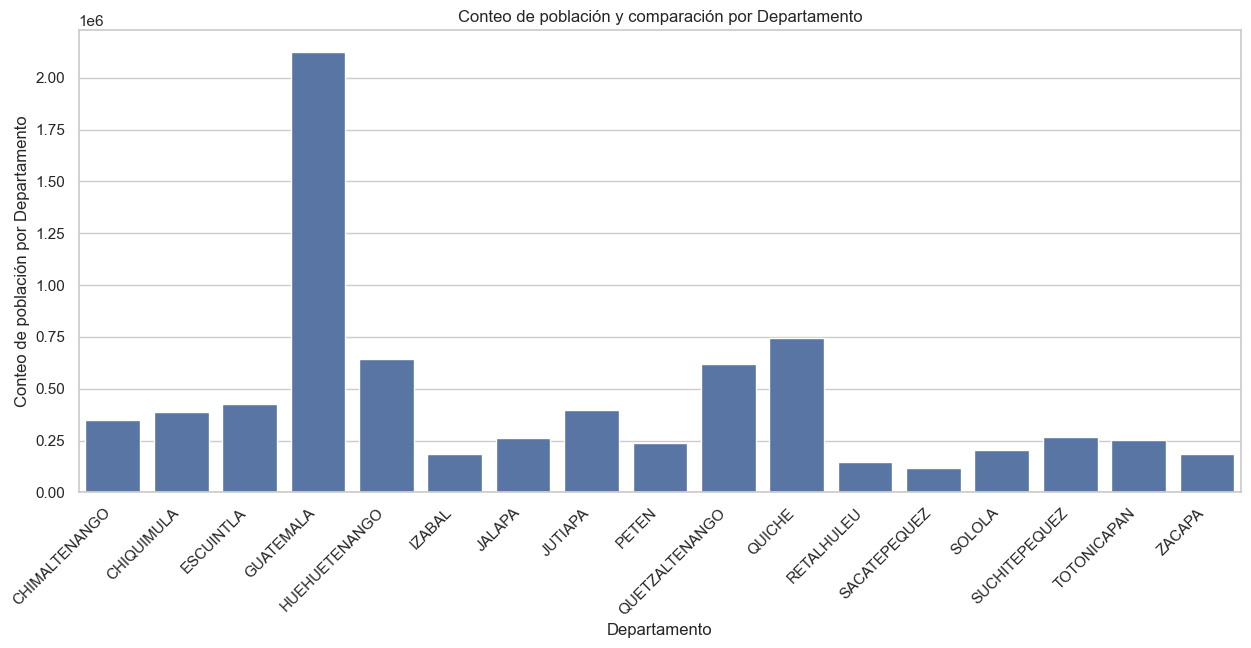

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


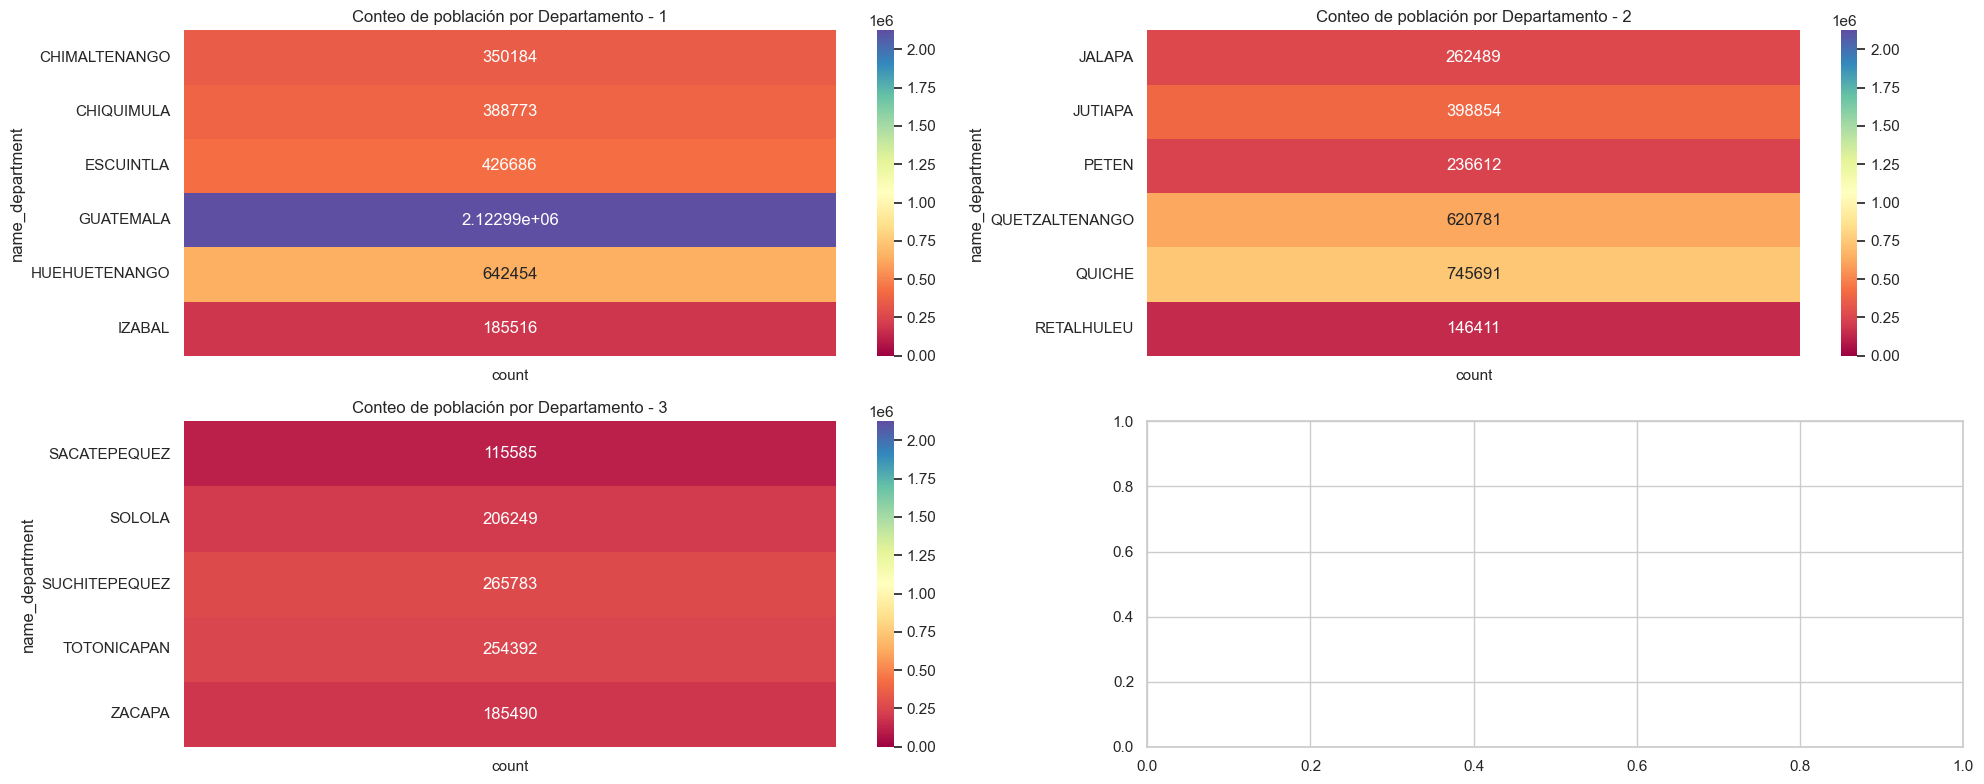

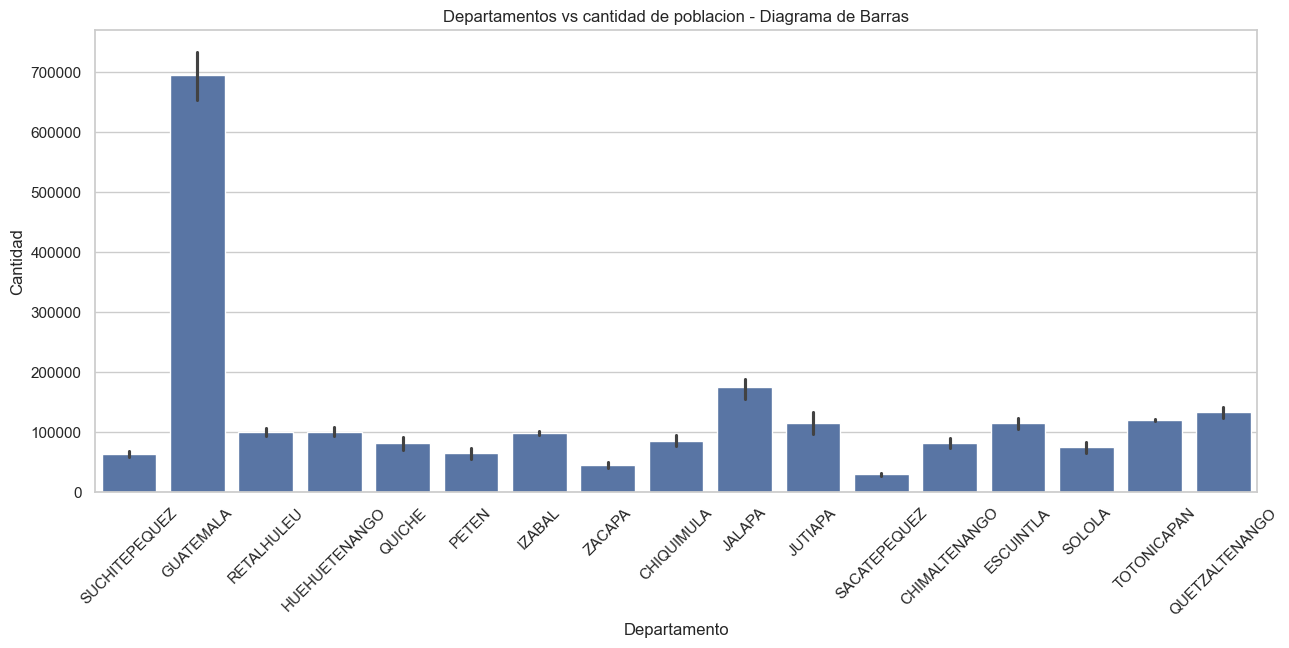

In [172]:
generate_sum_plot(df_municipality, 'population','name_department', 'Departamento', 'Conteo de población por Departamento', 'Conteo de población y comparación por Departamento')
generate_heatmaps(df_municipality, 'population', 'name_department', 'Departamento','Conteo de población por Departamento', 'Conteo de población y comparación por Departamento', 10, 8, 2, False)
generate_bar(df_mdp_gt_0, 'name_department', 'population', 'Departamento', 'Cantidad', 'Departamentos vs cantidad de poblacion')

#### **Municipios vs Cantidad de registros Nuevas Muertes por COVID-19 (2020)**

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px;table-layout: fixed; width: 372px" class="tg"><colgroup><col style="width: 164px"><col style="width: 38px"><col style="width: 24px"><col style="width: 88px"><col style="width: 29px"><col style="width: 29px"></colgroup><thead><tr><th style="background-color:#9a0000;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Municipio con más registros de nuevas muertes</th><th style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Municipio</th><th style="background-color:#036400;border-color:inherit;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal" colspan="3">Municipio con menos registros de nuevas muertes</th></tr></thead><tbody><tr><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">GUATEMALA</td><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">235</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">OLOPA</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal"></td></tr><tr><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">MIXCO</td><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">174</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TECTITAN</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal"></td></tr><tr><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUETZALTENANGO</td><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">126</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">CUNEN</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal"></td></tr><tr><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">ESCUINTLA</td><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">83</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SIPACATE</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal"></td></tr><tr><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">AMATITLAN</td><td style="background-color:#ffccc9;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">70</td><td style="background-color:#ffffff;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"></td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JEREZ</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#9aff99;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:bottom;word-break:normal"></td></tr></tbody></table>

El análisis de muertes por municipio en el año 2020 muestra un total de 1,813 registros. El municipio más frecuente es GUATEMALA con 235 casos. 

**Total de registros en 2020:** 1,813

Este análisis proporciona una visión detallada de cómo las nuevas muertes por COVID-19 se distribuyen entre diferentes municipios en el año 2020. Identificar los municipios con mayor incidencia es crucial para la planificación y ejecución de estrategias de salud pública a nivel local.

Además, se puede apreciar por la gráfica del mapa de calor qué municipios tienen una cantidad de casos mayor.

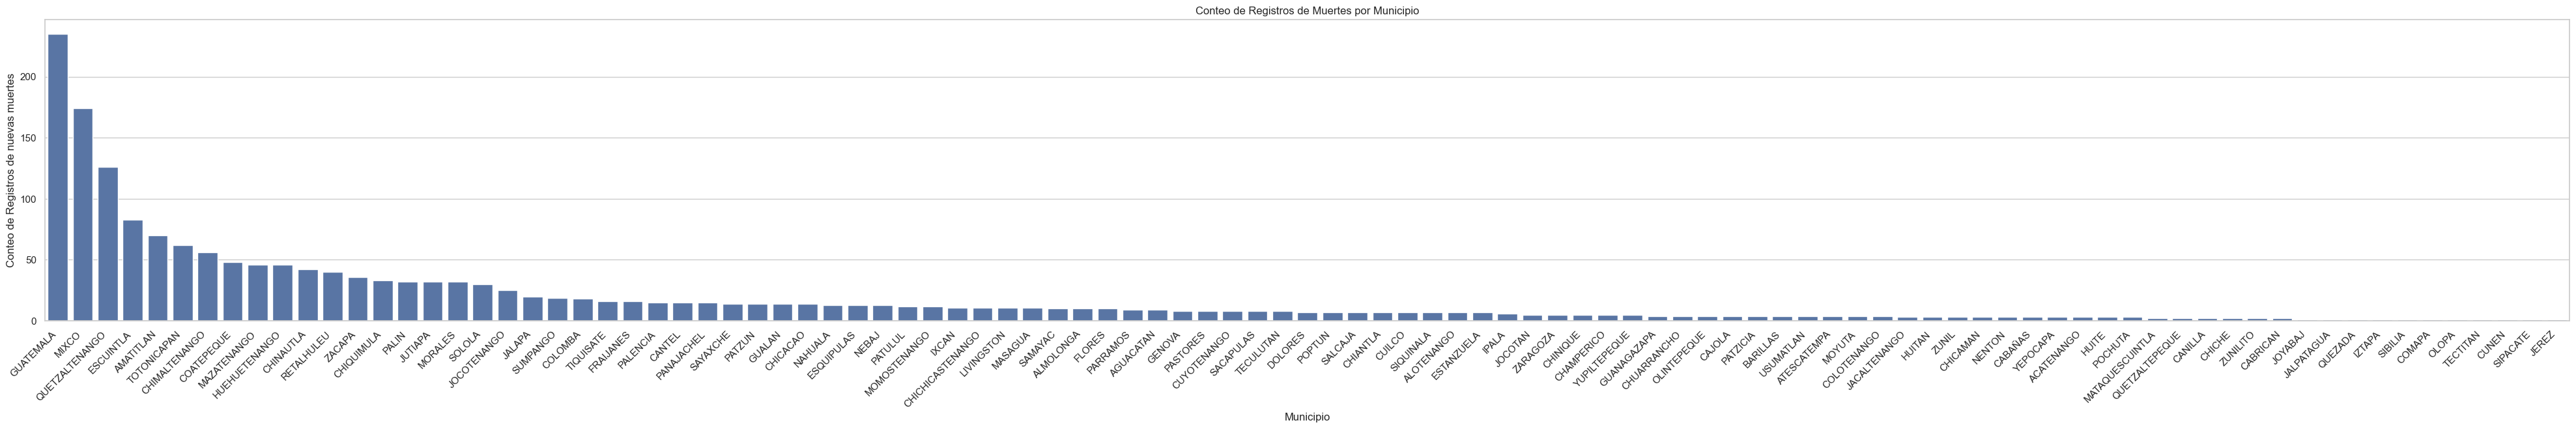

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


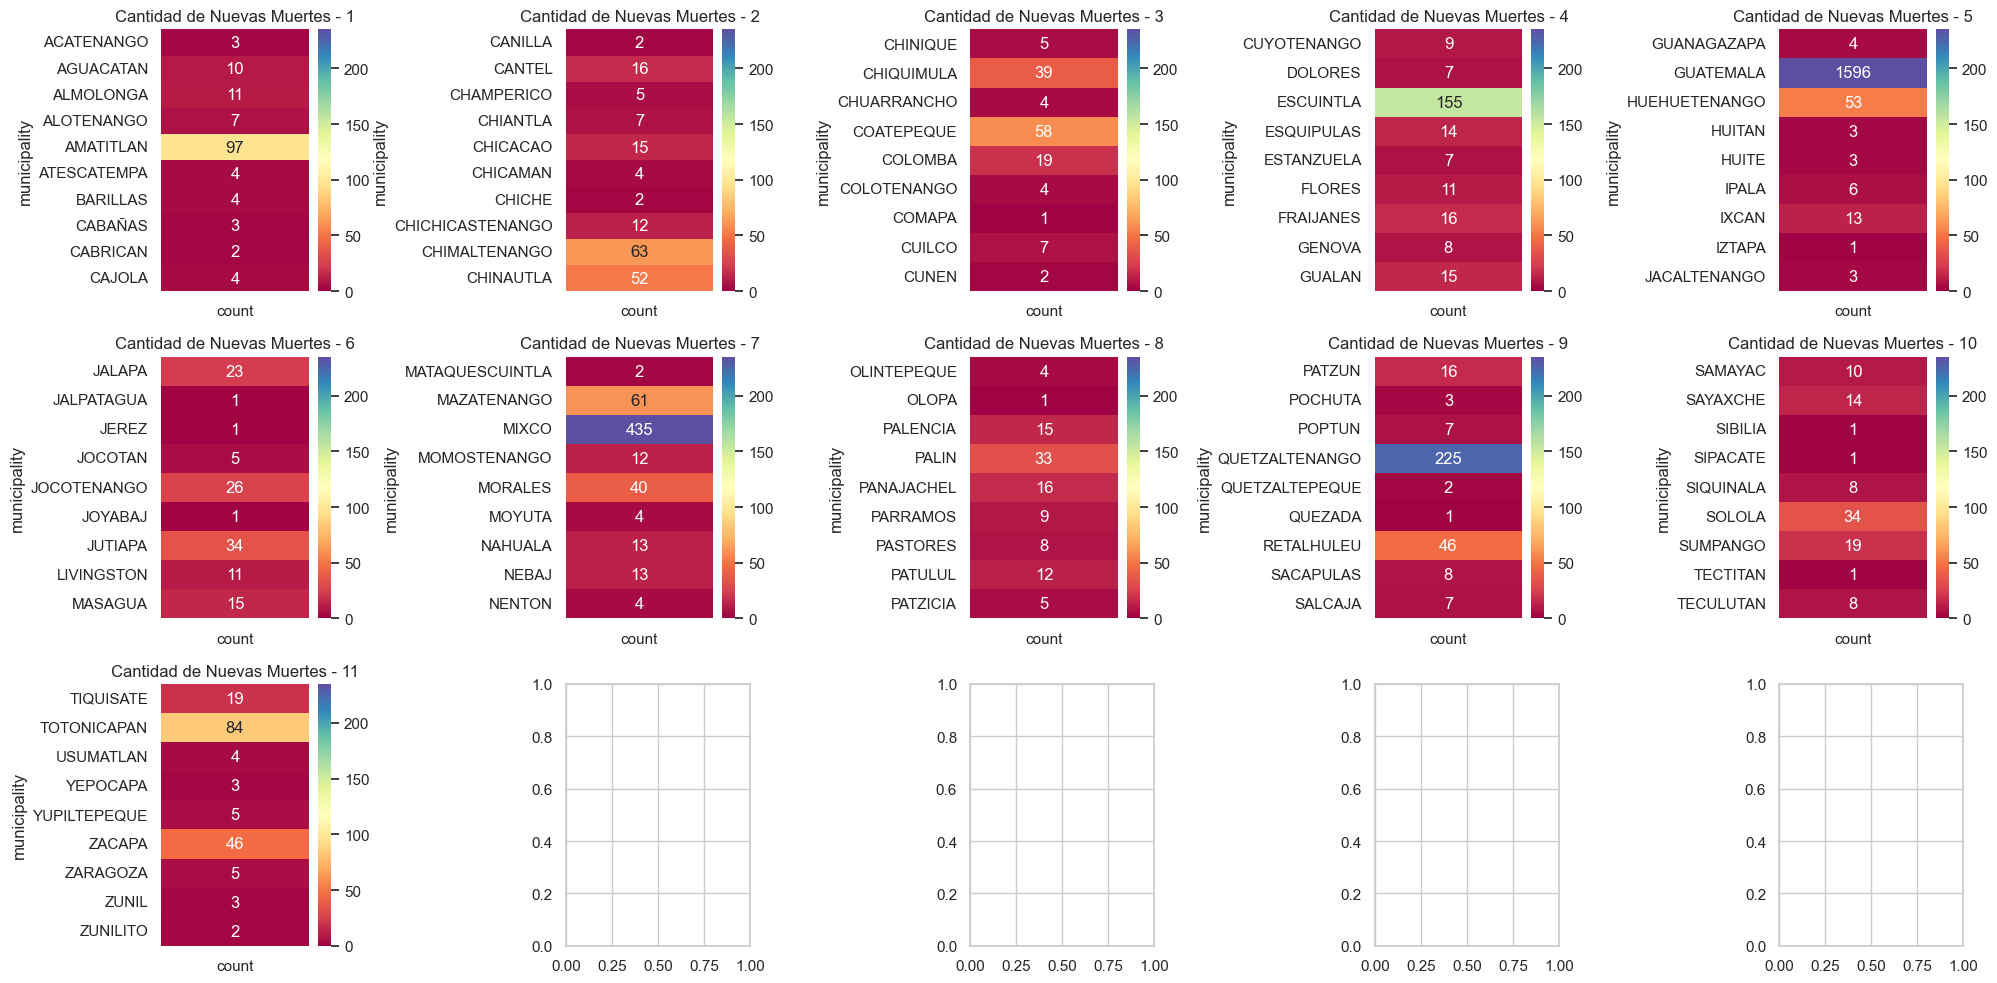

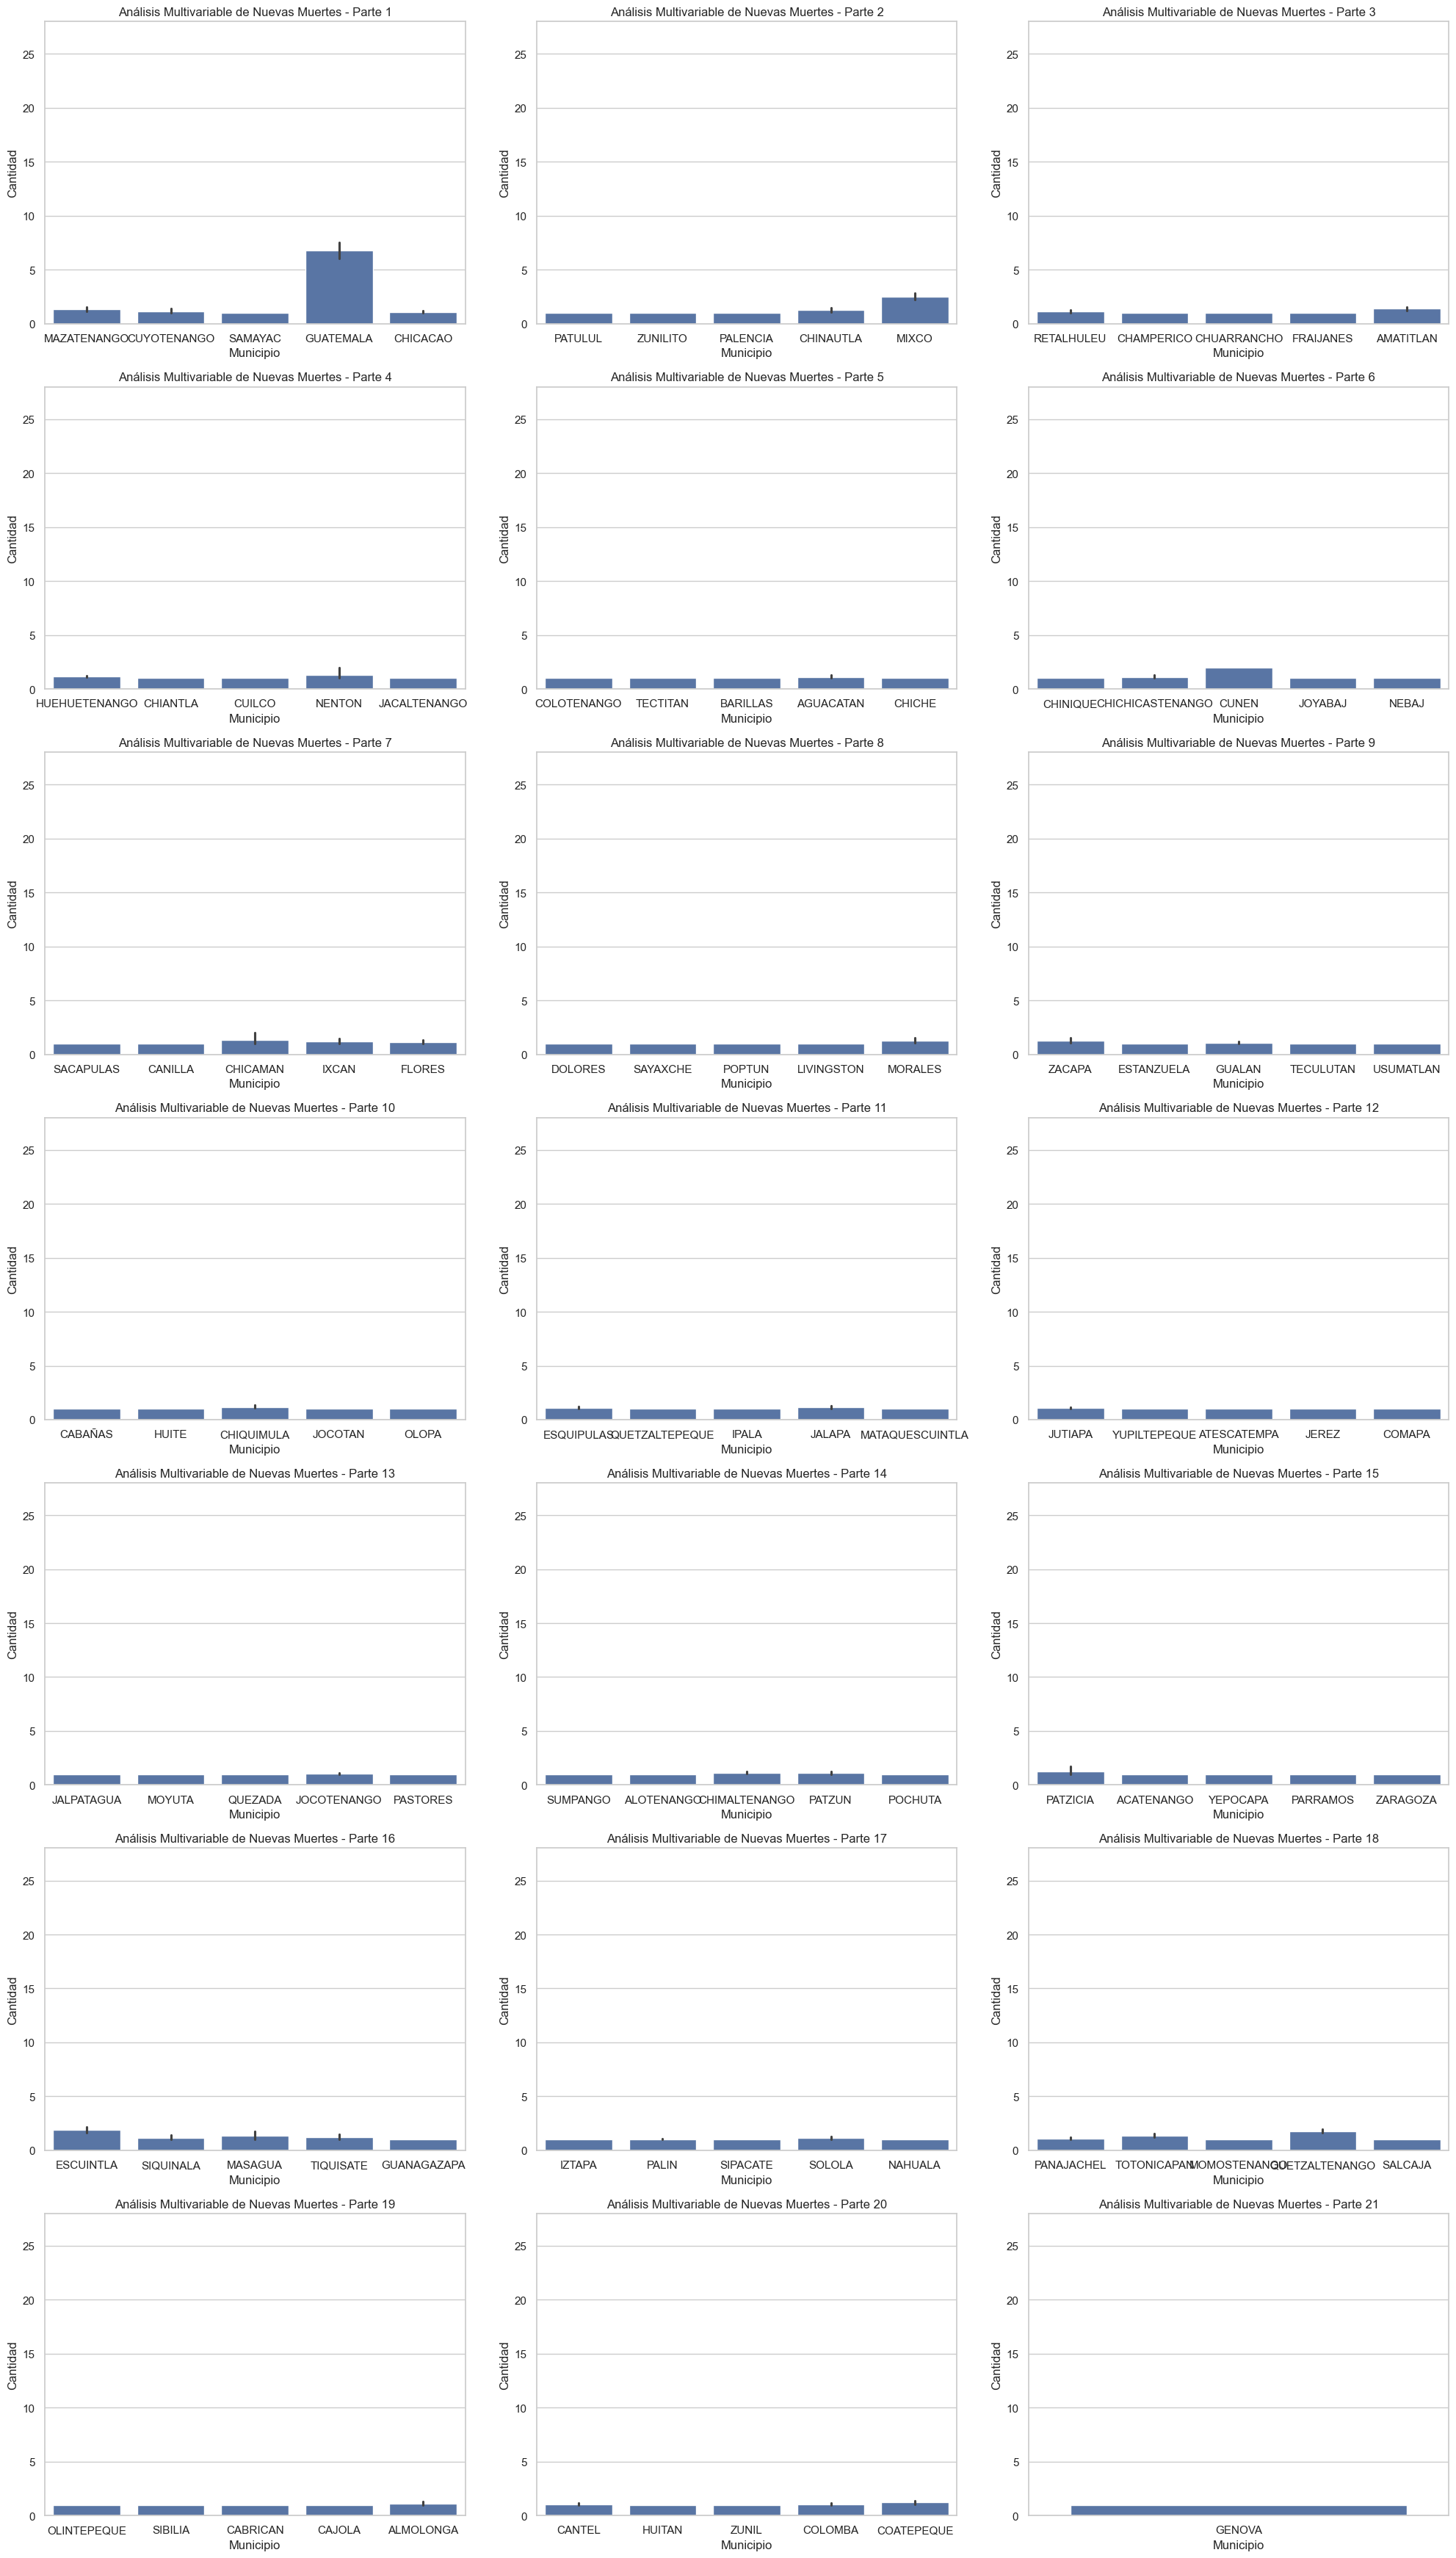

In [173]:
# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_mdp_gt_0, 'municipality', 'Municipio', 'Conteo de Registros de nuevas muertes', 'Conteo de Registros de Muertes por Municipio', True)
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'municipality', 'Municipio', 'Cantidad de Nuevas Muertes', 'Municipios vs cantidad de nuevas muertes', 1, 10, 5)
# generate_multivariable_bar(df_mdp_gt_0, 'municipality', 'new_deaths', 'Municipio', 'Cantidad', 'Análisis Multivariable de Nuevas Muertes')
generate_multivariable_bar_subplots(df_mdp_gt_0, 'municipality', 'new_deaths', 'Municipio', 'Cantidad', 'Análisis Multivariable de Nuevas Muertes', bars_per_subplot=5, subplots_per_row=3)

#### **Departamentos vs Cantidad de registros Nuevas Muertes por COVID-19 (2020)**

El Análisis de Muertes por Departamento muestra un total de 1813 registros. El Departamento más frecuente es GUATEMALA con 556 casos.

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px;table-layout: fixed; width: 819px" class="tg"><colgroup><col style="width: 212px"><col style="width: 36px"><col style="width: 25px"><col style="width: 189px"><col style="width: 69px"><col style="width: 25px"><col style="width: 209px"><col style="width: 54px"></colgroup><thead><tr><th style="background-color:#6434fc;border-color:#000000;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Departamentos vs Cantidad de registros de nuevas muertes</th><th style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></th><th style="background-color:#6434FC;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2"><span style="font-weight:normal;color:#FFF;background-color:#6434FC">Departamentos vs Cantidad de registros de nuevas muertes</span></th><th style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></th><th style="background-color:#6434FC;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2"><span style="font-weight:normal;color:#FFF;background-color:#6434FC">Departamentos vs Cantidad de registros de nuevas muertes</span></th></tr></thead><tbody><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">556</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">ZACAPA</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">75</span></td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">JUTIAPA</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">49</span></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">249</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">TOTONICAPAN</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">74</span></td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">RETALHULEU</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">45</span></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">155</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">CHIQUIMULA</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">60</span></td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">IZABAL</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">43</span></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">CHIMALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">97</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">SACATEPEQUEZ</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">59</span></td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">PETEN</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">38</span></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SUCHITEPEQUEZ</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">92</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">SOLOLA</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">58</span></td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">JALAPA</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">22</span></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">HUEHUETENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">84</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">QUICHE</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="color:#444;background-color:#CBCEFB">57</span></td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="font-weight:bold;color:#444;background-color:#CBCEFB">TOTAL</span></td><td style="background-color:#CBCEFB;border-color:#9ABAD9;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal"><span style="font-weight:bold;color:#444;background-color:#CBCEFB">1813</span></td></tr></tbody></table>

Este análisis proporciona una visión detallada de cómo las nuevas muertes por COVID-19 se distribuyeron en diferentes municipios durante el año 2020 en Guatemala. Identificar los municipios con mayor incidencia es crucial para la planificación y ejecución de estrategias de salud pública a nivel local.

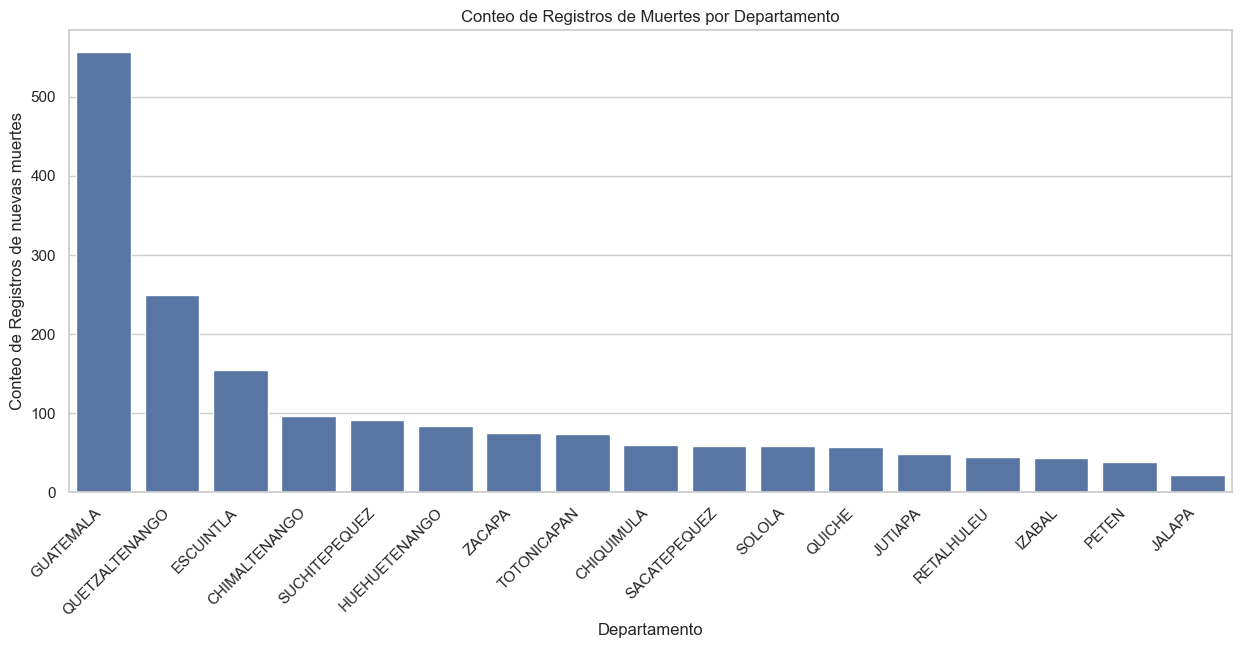

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


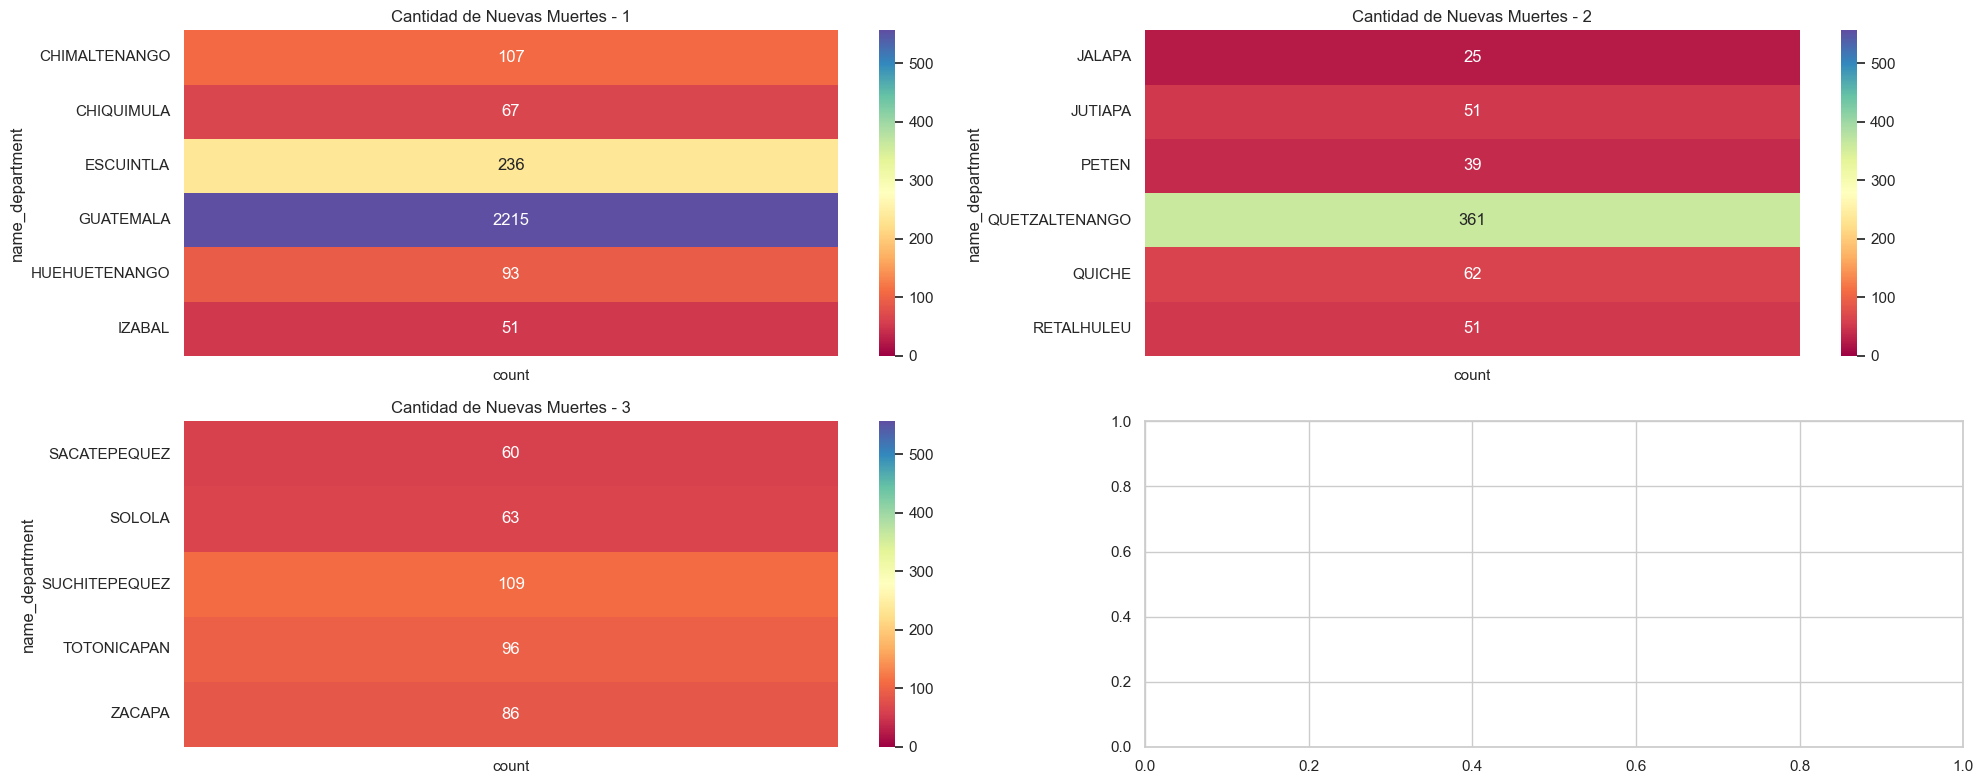

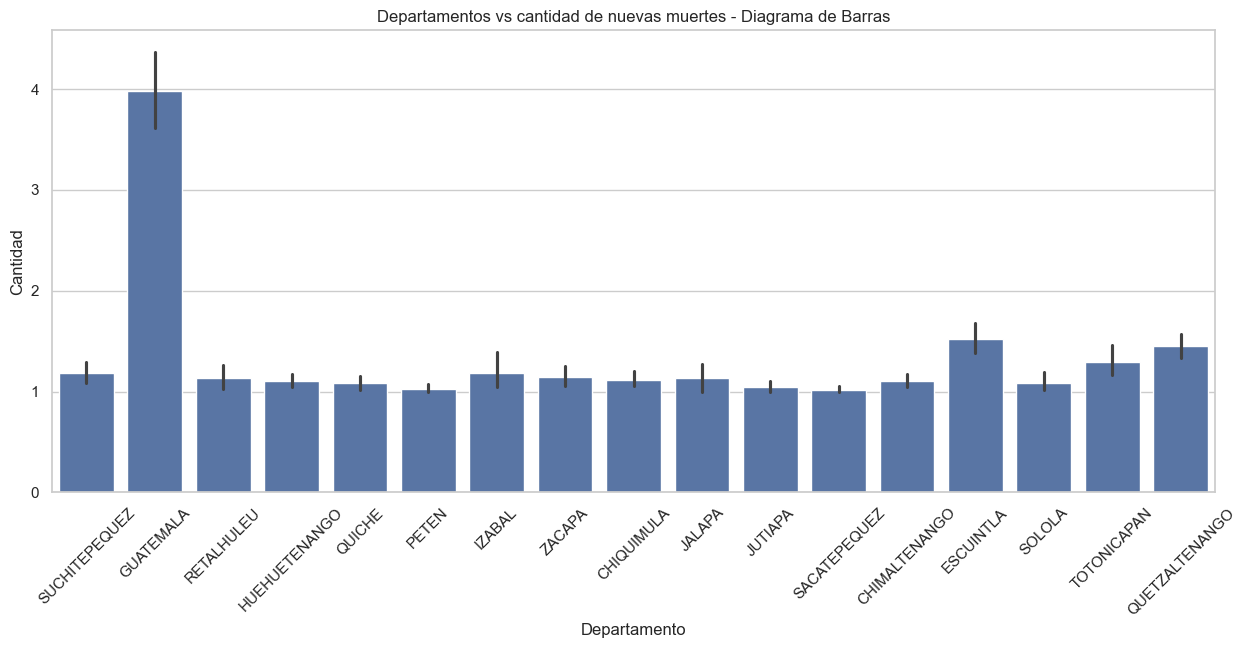

In [174]:
# Generar diagrama de barras para departamentos: cantidad de veces que aparecen en los casos de covid
generate_count_plot(df_mdp_gt_0, 'name_department', 'Departamento', 'Conteo de Registros de nuevas muertes', 'Conteo de Registros de Muertes por Departamento')
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'name_department', 'Departamento', 'Cantidad de Nuevas Muertes', 'Departamentos vs cantidad de nuevas muertes', 10, 8, 2)
generate_bar(df_mdp_gt_0, 'name_department', 'new_deaths', 'Departamento', 'Cantidad', 'Departamentos vs cantidad de nuevas muertes')

#### **Municipios vs Cantidad de Muertes Acumuladas**

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px;table-layout: fixed; width: 977px" class="tg"><colgroup><col style="width: 288px"><col style="width: 172px"><col style="width: 3px"><col style="width: 361px"><col style="width: 150px"><col style="width: 3px"></colgroup><thead><tr><th style="background-color:#6434fc;border-color:#000000;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Top 5 Municipios con más muertes acumuladas</th><th style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></th><th style="background-color:#6434FC;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Top 5 Municipios con menos muertes acumuladas</th><th style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></th></tr></thead><tbody><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Municipio</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Muertes Acumuladas</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Municipio</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Muertes acumuladas</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1596</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SIPACATE</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">MIXCO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">435</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SIBILIA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">225</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JOYABAJ</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">155</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">OLOPA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">AMATITLAN</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">97</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">TECTITAN</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">1</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr></tbody></table>

**Cantidad total de datos de Conteo de Registros de Muertes Acumuladas por Municipio en 2020: 3772**

Este análisis destaca la concentración de muertes acumuladas en algunos municipios específicos durante el año 2020 en Guatemala. La información actualizada proporciona una visión detallada de la distribución de nuevas muertes y muertes acumuladas en diferentes municipios, lo que puede ser crucial para la toma de decisiones en políticas de salud pública a nivel local. La variabilidad en los números también sugiere posibles disparidades en la gestión de la crisis sanitaria a nivel municipal.

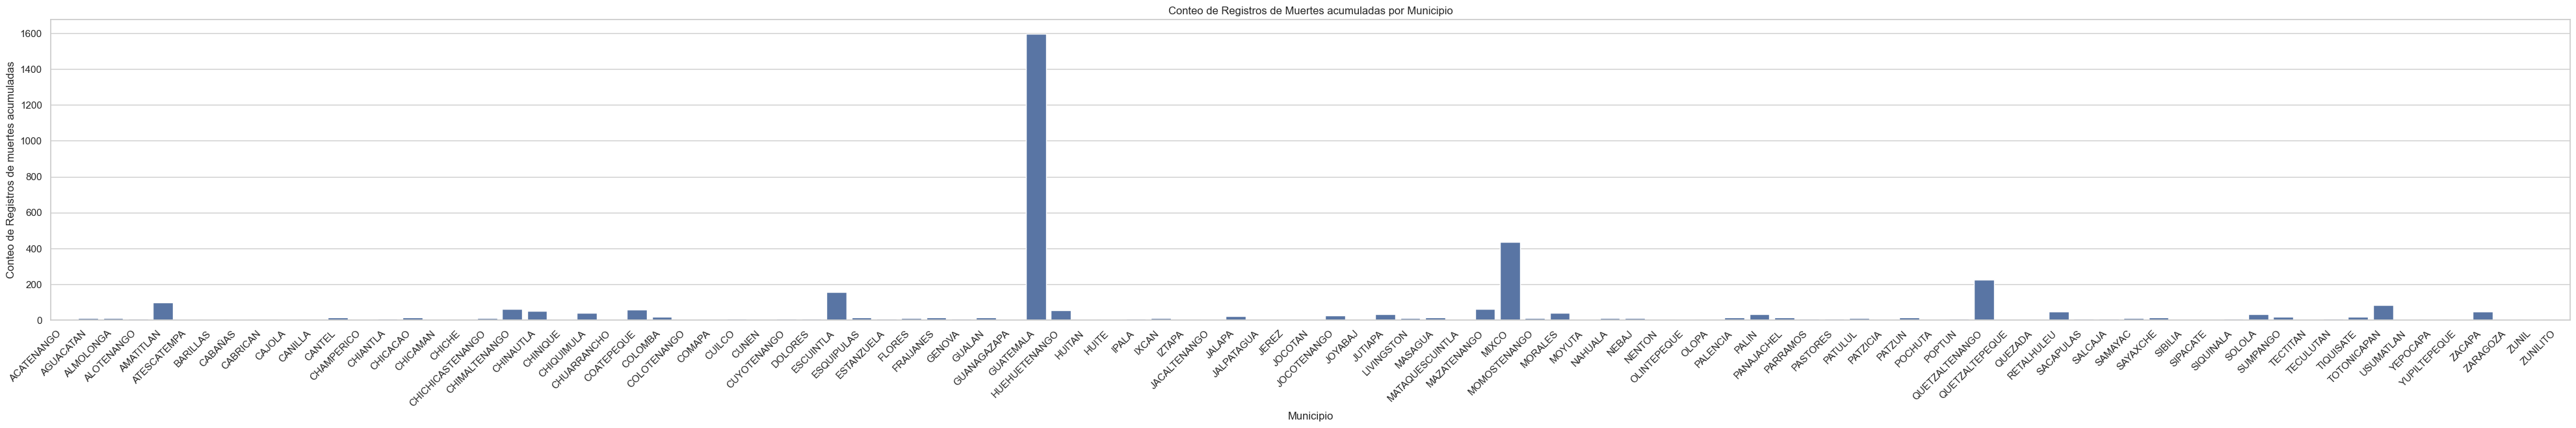

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


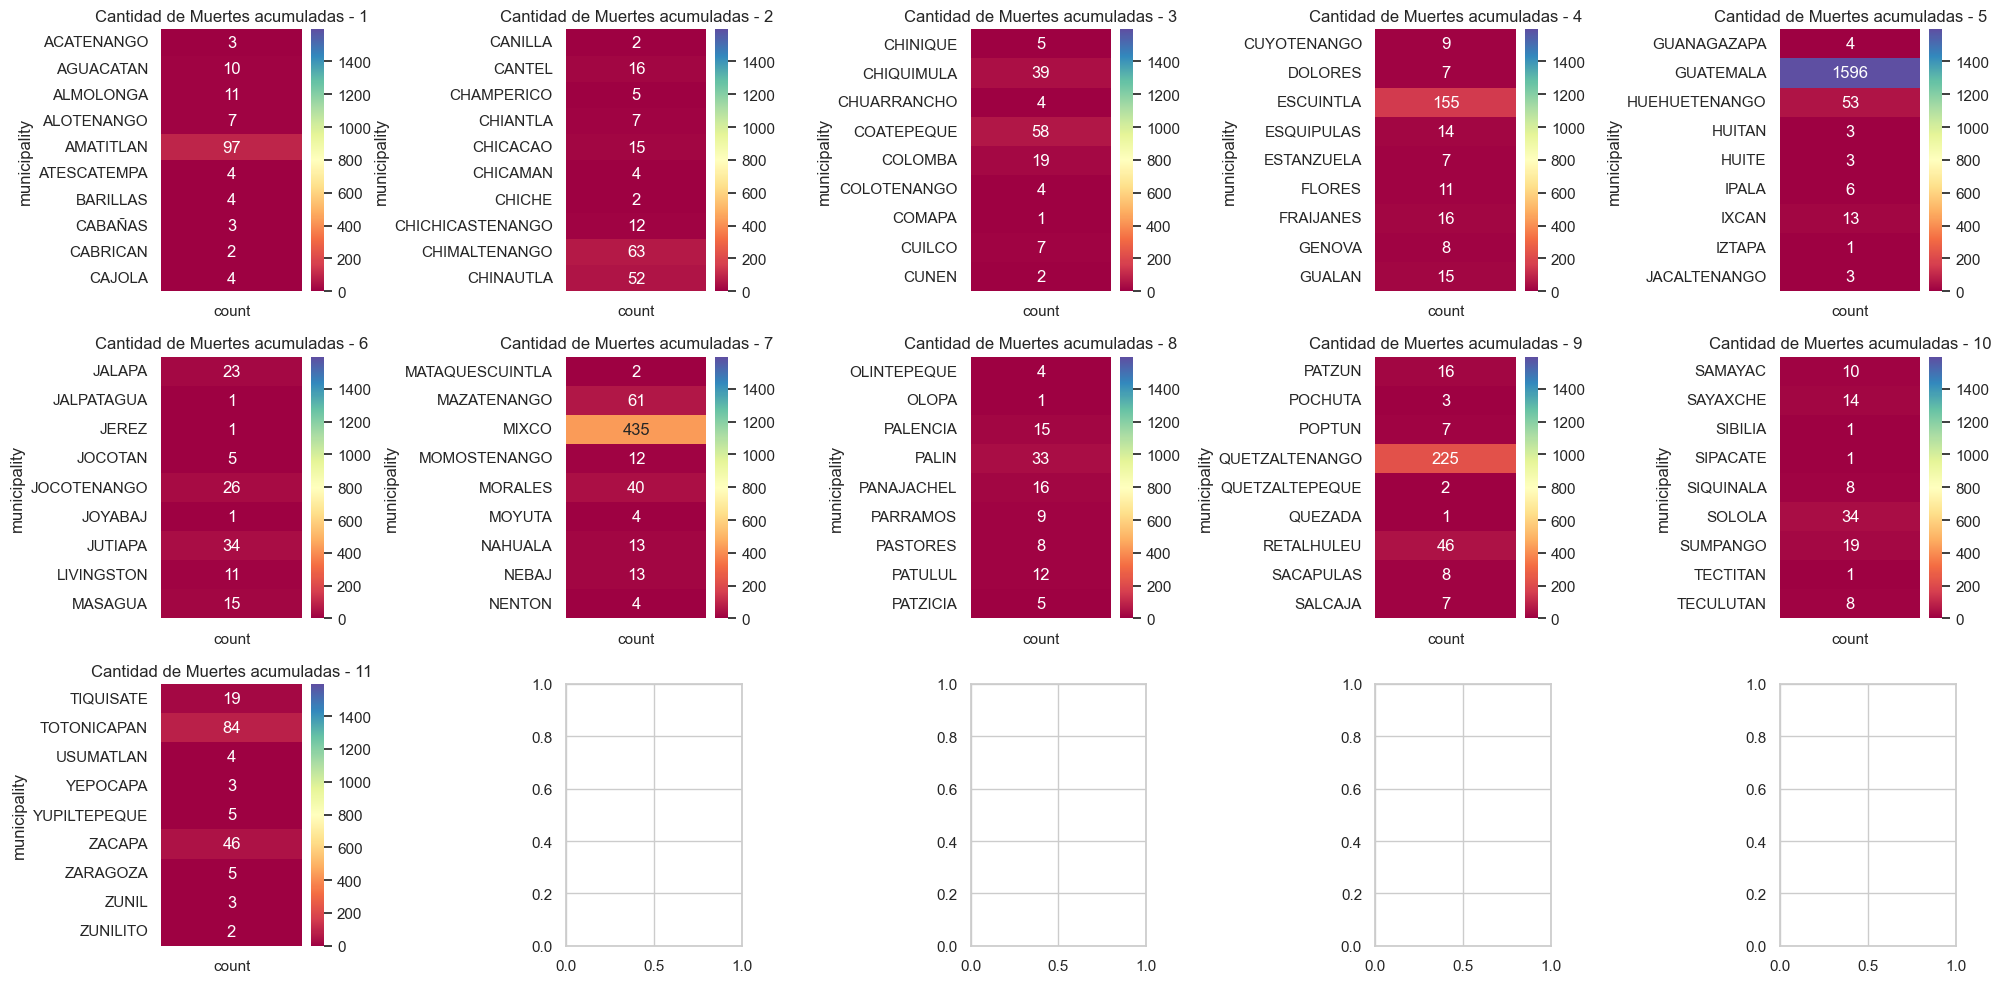

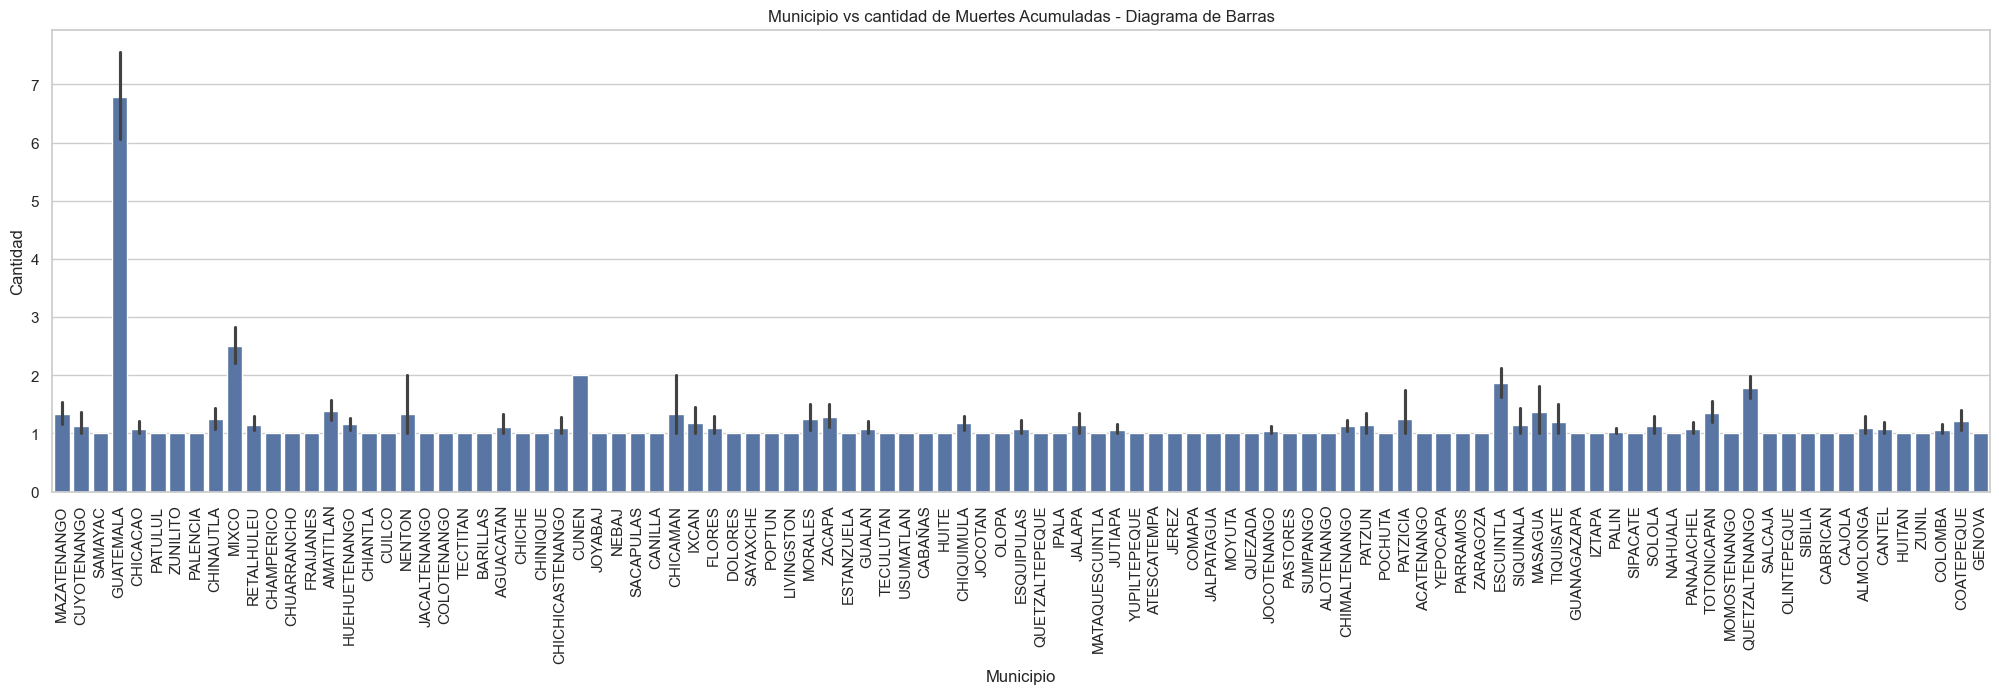

In [175]:
# Generar diagrama de barras para municipios: cantidad de veces que aparecen en los casos de covid
generate_sum_plot(df_mdp_gt_0, 'new_deaths','municipality', 'Municipio', 'Conteo de Registros de muertes acumuladas', 'Conteo de Registros de Muertes acumuladas por Municipio', True)
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'municipality', 'Municipio', 'Cantidad de Muertes acumuladas', 'Municipios vs cantidad de muertes acumuladas', 1, 10, 5, False)
generate_bar(df_mdp_gt_0, 'municipality', 'new_deaths', 'Municipio', 'Cantidad', 'Municipio vs cantidad de Muertes Acumuladas', 90, True)

#### **Departamentos vs Cantidad de Muertes Acumuladas**

<table style="border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;border-style:solid;border-width:1px;table-layout: fixed; width: 977px" class="tg"><colgroup><col style="width: 288px"><col style="width: 172px"><col style="width: 3px"><col style="width: 361px"><col style="width: 150px"><col style="width: 3px"></colgroup><thead><tr><th style="background-color:#6434fc;border-color:#000000;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Top 5 Departamentos con más Muertes Acumuladas en 2020</th><th style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></th><th style="background-color:#6434FC;border-color:inherit;border-style:solid;border-width:0px;color:#FFF;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal" colspan="2">Top 5 Departamentos con menos Muertes Acumuladsa en 2020</th><th style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#fff;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></th></tr></thead><tbody><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Departamento</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Muertes Acumuladas</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Departamento</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">Muertes Acumuladas</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">GUATEMALA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">2215</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JUTIAPA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">51</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">QUETZALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">361</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">RETALHULEU</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">51</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">ESCUINTLA</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">236</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">IZABAL</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">51</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">SUCHITEPEQUEZ</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">109</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">PETEN</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">39</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr><tr><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">CHIMALTENANGO</td><td style="background-color:#cbcefb;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">107</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">JALAPA</td><td style="background-color:#CBCEFB;border-color:inherit;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:center;vertical-align:top;word-break:normal">25</td><td style="background-color:#343434;border-color:#000000;border-style:solid;border-width:0px;color:#444;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal"></td></tr></tbody></table>

**Cantidad total de datos de Conteo de Muertes Acumuladas por Departamento en 2020: 3772**

Este análisis resalta la variabilidad en la cantidad de muertes acumuladas en diferentes departamentos durante el año 2020 en Guatemala. La información actualizada proporciona una visión detallada de la distribución geográfica de la mortalidad, destacando los departamentos con mayor y menor incidencia. La variabilidad en los números sugiere posibles disparidades en la gestión de la crisis sanitaria a nivel departamental.

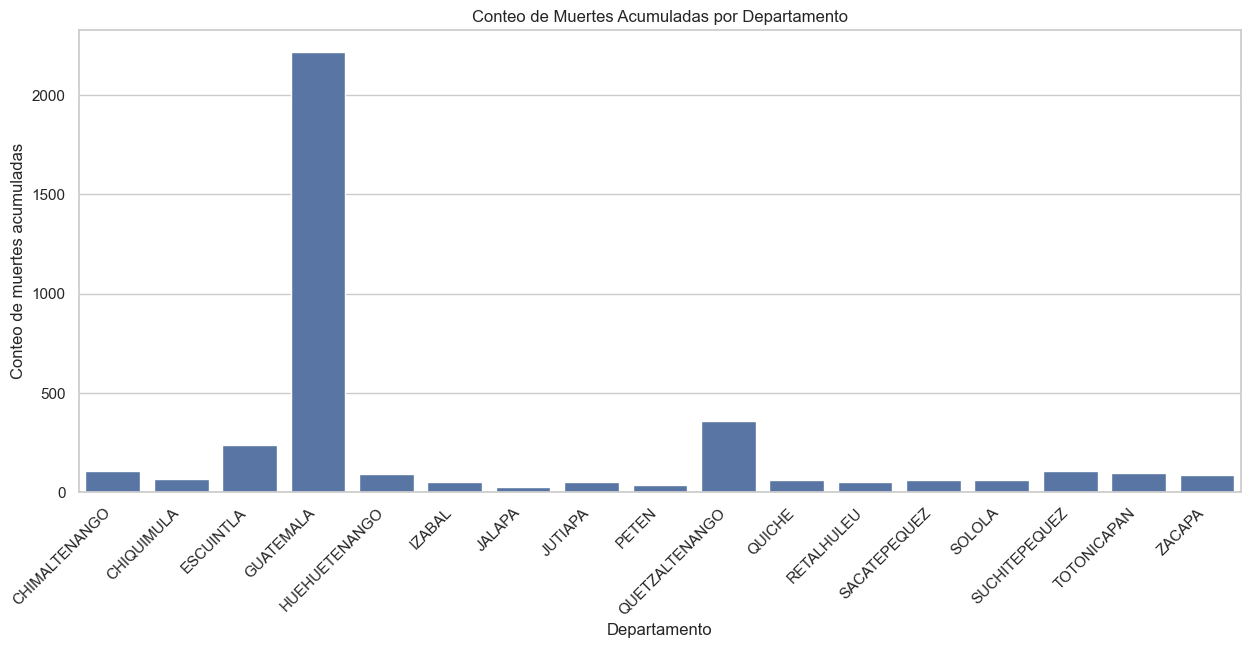

d:\Projects\SS2_Proyecto_Fase_1\Fase_2\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


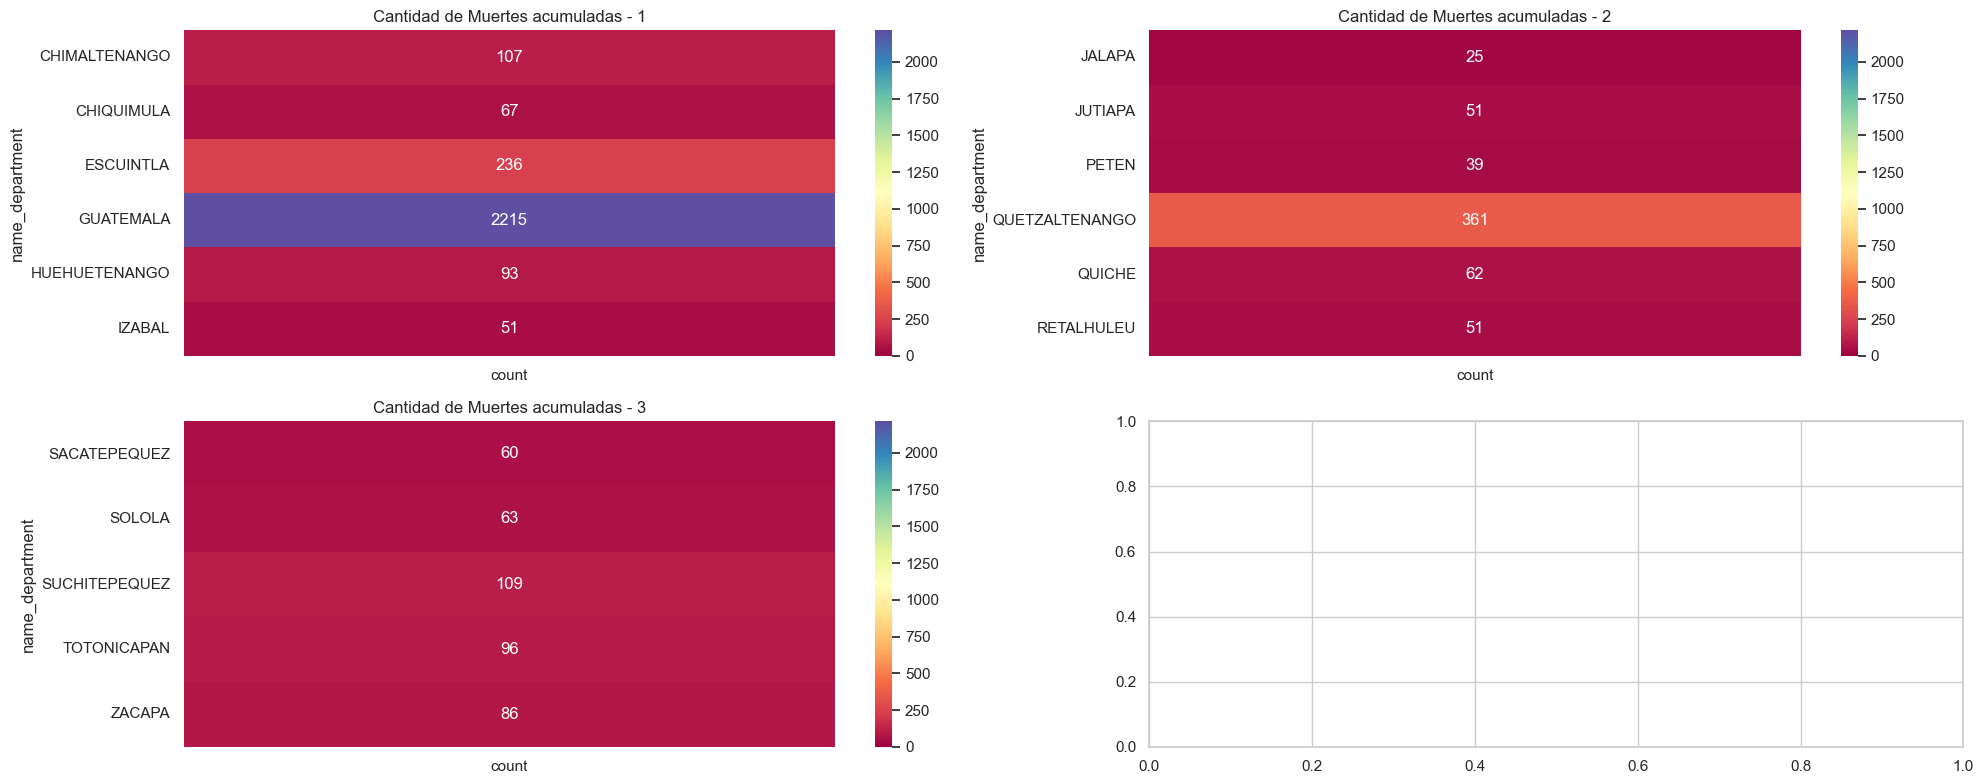

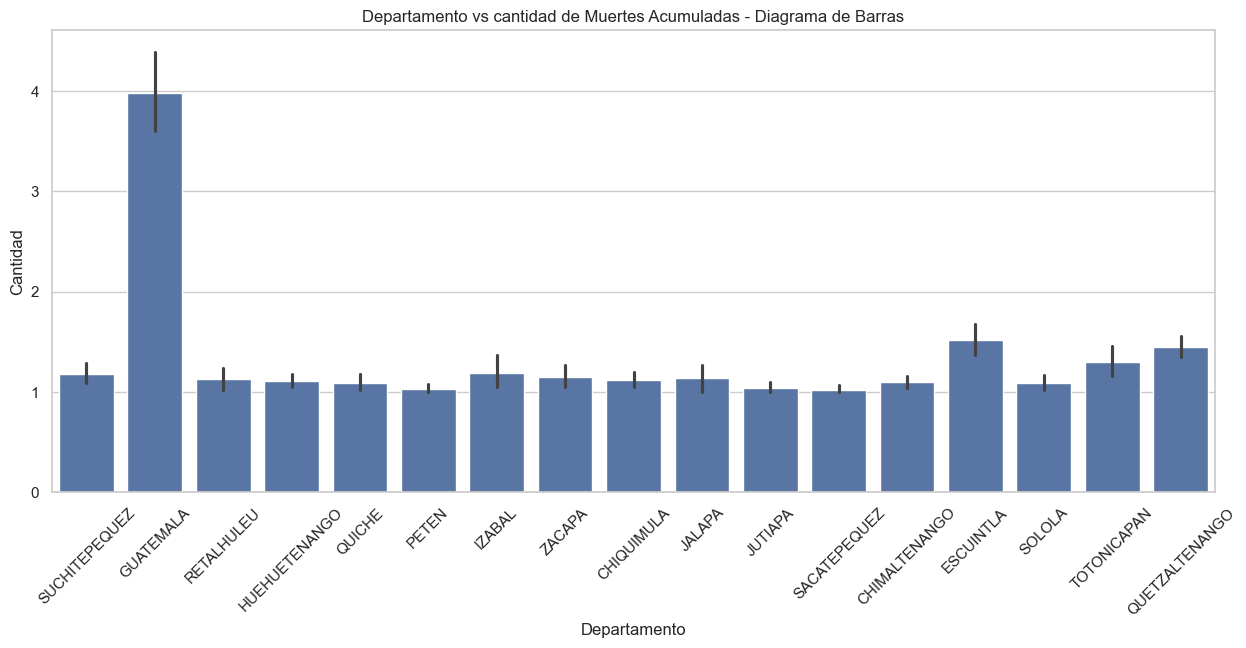

In [176]:
# Generar diagrama de barras para departamentos: cantidad de veces que aparecen en los casos de covid
generate_sum_plot(df_mdp_gt_0, 'new_deaths','name_department', 'Departamento', 'Conteo de muertes acumuladas', 'Conteo de Muertes Acumuladas por Departamento', False)
generate_heatmaps(df_mdp_gt_0, 'new_deaths', 'name_department', 'Departamento', 'Cantidad de Muertes acumuladas', 'Departamentos vs cantidad de muertes acumuladas', 10, 8, 2, False)
generate_bar(df_mdp_gt_0, 'name_department', 'new_deaths', 'Departamento', 'Cantidad', 'Departamento vs cantidad de Muertes Acumuladas', 45)

## **Conclusiones**

1. **Población por Municipio y Departamento:**
   - El municipio más poblado es **Guatemala** con una población de 1,205,668 personas, mientras que el departamento más poblado es también **Guatemala** con 2,122,986 personas.
   - Existe una variabilidad significativa en la población entre los municipios y departamentos, destacando la concentración en áreas urbanas como Guatemala y Mixco.

2. **Nuevas Muertes y Muertes Acumuladas:**
   - **Guatemala** (tanto a nivel de departamento como municipio) muestra la mayor cantidad de nuevas muertes y muertes acumuladas. Esto destaca la necesidad de medidas preventivas y recursos adicionales en esta área.
   - Los diagramas de dispersión entre **Nuevas Muertes vs Muertes Acumuladas** por municipio y departamento indican una relación positiva, sugiriendo que los lugares con más nuevas muertes también tienden a tener más muertes acumuladas.

3. **Distribución Geográfica de Nuevas Muertes:**
   - El análisis de mapas de calor revela que los municipios de **Guatemala**, **Mixco**, y **Quetzaltenango** experimentan una cantidad significativa de nuevas muertes. Esto subraya la necesidad de estrategias específicas y atención en estas áreas.

4. **Muertes Acumuladas:**
   - **Guatemala** lidera en muertes acumuladas tanto a nivel de municipio como de departamento, seguido por **Mixco** y **Quetzaltenango**. Esta concentración destaca la importancia de recursos y esfuerzos adicionales en estas ubicaciones.

## Recomendaciones

1. **Asignación de Recursos:**
   - Priorizar la asignación de recursos y atención médica en áreas urbanas densamente pobladas, especialmente en el departamento y municipio de **Guatemala**, para gestionar efectivamente la carga de nuevas muertes y muertes acumuladas.

2. **Medidas Preventivas:**
   - Implementar medidas preventivas y campañas de concientización en los municipios y departamentos con mayores tasas de nuevas muertes, como **Guatemala**, **Mixco**, y **Quetzaltenango**.

3. **Planificación Estratégica:**
   - Desarrollar planes estratégicos específicos para abordar las disparidades en la distribución geográfica de las muertes acumuladas. Esto puede incluir campañas de vacunación, recursos adicionales para el sistema de salud y medidas de mitigación.

4. **Monitoreo Continuo:**
   - Establecer un sistema de monitoreo continuo para evaluar la evolución de la situación en cada municipio y departamento. Esto permitirá una respuesta rápida y ajustes en las estrategias según sea necesario.

5. **Coordinación Interdepartamental:**
   - Fomentar la coordinación y colaboración entre los departamentos para compartir mejores prácticas, recursos y estrategias efectivas. El intercambio de información facilitará una respuesta más eficiente y coordinada a nivel nacional.

**NOTA:** Estas conclusiones y recomendaciones están basadas en el análisis de los datos proporcionados y buscan proporcionar orientación para abordar los desafíos específicos relacionados con la pandemia de COVID-19 en Guatemala. Es esencial adaptar las estrategias a la evolución de la situación y considerar la dinámica única de cada región.